In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#!pip3 install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn.model_selection import KFold


In [2]:
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
#df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')
#df_final_train.columns
# df_final_train = read_hdf('storage_sample_stage_final.h5', 'train_df',mode='r')
# df_final_test = read_hdf('storage_sample_stage_final.h5', 'test_df',mode='r')
# df_final_train.columns
df_final_train.head()

,source,destination,connected,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees
0,1,690569,1,0,0.090909,0.039817,0.251976,3,29,3,...,2.979445e-07,3.726469e-06,0.000722,0.000819,8.549207e-18,1.690629e-16,3.812413e-18,3.942273e-16,87,63
1,18,1003537,1,0,0.058824,0.092450,0.149071,13,3,15,...,1.111717e-06,3.046637e-07,0.000759,0.000721,1.583866e-17,9.329002e-20,6.343111e-18,1.297053e-19,39,45
2,25,992602,1,0,0.242424,0.138866,0.440386,21,11,30,...,1.249942e-06,6.286333e-07,0.000790,0.000753,1.054783e-13,6.601673e-14,6.990593e-15,3.079403e-15,231,330
3,61,1408376,1,0,0.315789,0.151523,0.514496,8,7,17,...,6.565506e-07,4.826817e-07,0.000740,0.000736,2.768741e-19,2.050358e-19,6.563911e-21,6.826043e-21,56,136
4,62,402932,1,0,0.000000,0.149071,0.000000,5,3,3,...,4.097580e-07,8.216330e-07,0.000729,0.000721,3.984634e-18,-0.000000e+00,1.731093e-16,2.732624e-19,15,0


In [3]:
y_train = df_final_train.connected

In [4]:
df_final_train.drop(['source', 'destination','connected'],axis=1,inplace=True)

## Neural Network

In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
%%time
X_train, X_test, y_train_split, y_test_split = train_test_split(df_final_train, y_train, test_size=0.33, random_state=25)


hidden_units=200
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=2000

model = Sequential()

model.add(Dense(hidden_units, activation=hidden_layer_act))
model.add(Dense(hidden_units, activation=hidden_layer_act))
model.add(Dense(hidden_units, activation=hidden_layer_act))
model.add(Dense(hidden_units, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act))

sgd=optimizers.SGD(lr=learning_rate)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=[f1_m,recall_m])


history=model.fit(X_train, y_train_split, epochs=no_epochs, batch_size=len(X_train),  verbose=2)

predictions = model.predict(X_test)

rounded = [int(round(x[0])) for x in predictions]

#f1_m(y_test_split, rounded)
#recall_m(y_test_split, rounded)

Epoch 1/2000
1/1 - 2s - loss: 0.8501 - f1_m: 0.6544 - recall_m: 0.8968 - 2s/epoch - 2s/step
Epoch 2/2000
1/1 - 1s - loss: 2.4306 - f1_m: 0.6665 - recall_m: 1.0000 - 756ms/epoch - 756ms/step
Epoch 3/2000
1/1 - 0s - loss: 0.6985 - f1_m: 0.6690 - recall_m: 0.9953 - 493ms/epoch - 493ms/step
Epoch 4/2000
1/1 - 0s - loss: 3.4391 - f1_m: 0.2476 - recall_m: 0.1880 - 456ms/epoch - 456ms/step
Epoch 5/2000
1/1 - 0s - loss: 71.3999 - f1_m: 0.6665 - recall_m: 1.0000 - 460ms/epoch - 460ms/step
Epoch 6/2000
1/1 - 0s - loss: 46.1041 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - 469ms/epoch - 469ms/step
Epoch 7/2000
1/1 - 0s - loss: 194.3926 - f1_m: 0.6665 - recall_m: 1.0000 - 436ms/epoch - 436ms/step
Epoch 8/2000
1/1 - 0s - loss: 2.7553 - f1_m: 0.6665 - recall_m: 1.0000 - 481ms/epoch - 481ms/step
Epoch 9/2000
1/1 - 0s - loss: 1.3820 - f1_m: 0.6665 - recall_m: 1.0000 - 443ms/epoch - 443ms/step
Epoch 10/2000
1/1 - 0s - loss: 0.9350 - f1_m: 0.6665 - recall_m: 1.0000 - 492ms/epoch - 492ms/step
Epoch 11/2000

Epoch 84/2000
1/1 - 0s - loss: 0.5079 - f1_m: 0.7961 - recall_m: 0.7514 - 480ms/epoch - 480ms/step
Epoch 85/2000
1/1 - 0s - loss: 0.5158 - f1_m: 0.8103 - recall_m: 0.8125 - 462ms/epoch - 462ms/step
Epoch 86/2000
1/1 - 0s - loss: 0.5063 - f1_m: 0.7960 - recall_m: 0.7503 - 464ms/epoch - 464ms/step
Epoch 87/2000
1/1 - 0s - loss: 0.5142 - f1_m: 0.8103 - recall_m: 0.8111 - 448ms/epoch - 448ms/step
Epoch 88/2000
1/1 - 0s - loss: 0.5049 - f1_m: 0.7956 - recall_m: 0.7490 - 481ms/epoch - 481ms/step
Epoch 89/2000
1/1 - 0s - loss: 0.5129 - f1_m: 0.8106 - recall_m: 0.8105 - 454ms/epoch - 454ms/step
Epoch 90/2000
1/1 - 0s - loss: 0.5033 - f1_m: 0.7952 - recall_m: 0.7476 - 483ms/epoch - 483ms/step
Epoch 91/2000
1/1 - 0s - loss: 0.5113 - f1_m: 0.8106 - recall_m: 0.8095 - 464ms/epoch - 464ms/step
Epoch 92/2000
1/1 - 0s - loss: 0.5019 - f1_m: 0.7948 - recall_m: 0.7465 - 463ms/epoch - 463ms/step
Epoch 93/2000
1/1 - 0s - loss: 0.5100 - f1_m: 0.8106 - recall_m: 0.8086 - 482ms/epoch - 482ms/step
Epoch 94/2

1/1 - 0s - loss: 0.4579 - f1_m: 0.7951 - recall_m: 0.7322 - 435ms/epoch - 435ms/step
Epoch 167/2000
1/1 - 0s - loss: 0.4791 - f1_m: 0.8150 - recall_m: 0.8084 - 447ms/epoch - 447ms/step
Epoch 168/2000
1/1 - 0s - loss: 0.4562 - f1_m: 0.7966 - recall_m: 0.7365 - 434ms/epoch - 434ms/step
Epoch 169/2000
1/1 - 0s - loss: 0.4634 - f1_m: 0.8129 - recall_m: 0.7940 - 448ms/epoch - 448ms/step
Epoch 170/2000
1/1 - 0s - loss: 0.4564 - f1_m: 0.7952 - recall_m: 0.7322 - 433ms/epoch - 433ms/step
Epoch 171/2000
1/1 - 0s - loss: 0.5045 - f1_m: 0.8182 - recall_m: 0.8311 - 441ms/epoch - 441ms/step
Epoch 172/2000
1/1 - 0s - loss: 0.4587 - f1_m: 0.8037 - recall_m: 0.7570 - 429ms/epoch - 429ms/step
Epoch 173/2000
1/1 - 0s - loss: 0.4591 - f1_m: 0.8130 - recall_m: 0.7921 - 430ms/epoch - 430ms/step
Epoch 174/2000
1/1 - 0s - loss: 0.4551 - f1_m: 0.8000 - recall_m: 0.7428 - 450ms/epoch - 450ms/step
Epoch 175/2000
1/1 - 0s - loss: 0.4629 - f1_m: 0.8138 - recall_m: 0.7970 - 434ms/epoch - 434ms/step
Epoch 176/2000


1/1 - 0s - loss: 0.4352 - f1_m: 0.8211 - recall_m: 0.8062 - 448ms/epoch - 448ms/step
Epoch 249/2000
1/1 - 0s - loss: 0.4229 - f1_m: 0.8044 - recall_m: 0.7441 - 432ms/epoch - 432ms/step
Epoch 250/2000
1/1 - 0s - loss: 0.4385 - f1_m: 0.8223 - recall_m: 0.8113 - 441ms/epoch - 441ms/step
Epoch 251/2000
1/1 - 0s - loss: 0.4220 - f1_m: 0.8053 - recall_m: 0.7453 - 457ms/epoch - 457ms/step
Epoch 252/2000
1/1 - 0s - loss: 0.4327 - f1_m: 0.8214 - recall_m: 0.8062 - 436ms/epoch - 436ms/step
Epoch 253/2000
1/1 - 0s - loss: 0.4217 - f1_m: 0.8049 - recall_m: 0.7446 - 449ms/epoch - 449ms/step
Epoch 254/2000
1/1 - 0s - loss: 0.4449 - f1_m: 0.8248 - recall_m: 0.8195 - 459ms/epoch - 459ms/step
Epoch 255/2000
1/1 - 0s - loss: 0.4199 - f1_m: 0.8072 - recall_m: 0.7491 - 424ms/epoch - 424ms/step
Epoch 256/2000
1/1 - 0s - loss: 0.4269 - f1_m: 0.8208 - recall_m: 0.8017 - 453ms/epoch - 453ms/step
Epoch 257/2000
1/1 - 0s - loss: 0.4199 - f1_m: 0.8055 - recall_m: 0.7460 - 427ms/epoch - 427ms/step
Epoch 258/2000


1/1 - 0s - loss: 0.4050 - f1_m: 0.8296 - recall_m: 0.8125 - 458ms/epoch - 458ms/step
Epoch 331/2000
1/1 - 0s - loss: 0.3993 - f1_m: 0.8158 - recall_m: 0.7577 - 437ms/epoch - 437ms/step
Epoch 332/2000
1/1 - 0s - loss: 0.4130 - f1_m: 0.8325 - recall_m: 0.8241 - 453ms/epoch - 453ms/step
Epoch 333/2000
1/1 - 0s - loss: 0.4000 - f1_m: 0.8150 - recall_m: 0.7550 - 434ms/epoch - 434ms/step
Epoch 334/2000
1/1 - 0s - loss: 0.4220 - f1_m: 0.8340 - recall_m: 0.8329 - 417ms/epoch - 417ms/step
Epoch 335/2000
1/1 - 0s - loss: 0.3990 - f1_m: 0.8160 - recall_m: 0.7568 - 451ms/epoch - 451ms/step
Epoch 336/2000
1/1 - 0s - loss: 0.4141 - f1_m: 0.8333 - recall_m: 0.8273 - 444ms/epoch - 444ms/step
Epoch 337/2000
1/1 - 0s - loss: 0.3989 - f1_m: 0.8156 - recall_m: 0.7560 - 438ms/epoch - 438ms/step
Epoch 338/2000
1/1 - 0s - loss: 0.4199 - f1_m: 0.8349 - recall_m: 0.8340 - 418ms/epoch - 418ms/step
Epoch 339/2000
1/1 - 0s - loss: 0.3983 - f1_m: 0.8171 - recall_m: 0.7581 - 420ms/epoch - 420ms/step
Epoch 340/2000


1/1 - 0s - loss: 0.3843 - f1_m: 0.8265 - recall_m: 0.7706 - 498ms/epoch - 498ms/step
Epoch 413/2000
1/1 - 1s - loss: 0.4038 - f1_m: 0.8432 - recall_m: 0.8485 - 500ms/epoch - 500ms/step
Epoch 414/2000
1/1 - 1s - loss: 0.3839 - f1_m: 0.8273 - recall_m: 0.7717 - 523ms/epoch - 523ms/step
Epoch 415/2000
1/1 - 0s - loss: 0.4028 - f1_m: 0.8434 - recall_m: 0.8484 - 484ms/epoch - 484ms/step
Epoch 416/2000
1/1 - 0s - loss: 0.3834 - f1_m: 0.8274 - recall_m: 0.7719 - 479ms/epoch - 479ms/step
Epoch 417/2000
1/1 - 0s - loss: 0.4036 - f1_m: 0.8439 - recall_m: 0.8503 - 487ms/epoch - 487ms/step
Epoch 418/2000
1/1 - 0s - loss: 0.3831 - f1_m: 0.8280 - recall_m: 0.7729 - 463ms/epoch - 463ms/step
Epoch 419/2000
1/1 - 0s - loss: 0.4023 - f1_m: 0.8440 - recall_m: 0.8496 - 488ms/epoch - 488ms/step
Epoch 420/2000
1/1 - 0s - loss: 0.3827 - f1_m: 0.8280 - recall_m: 0.7726 - 458ms/epoch - 458ms/step
Epoch 421/2000
1/1 - 0s - loss: 0.4039 - f1_m: 0.8447 - recall_m: 0.8523 - 498ms/epoch - 498ms/step
Epoch 422/2000


1/1 - 0s - loss: 0.3707 - f1_m: 0.8386 - recall_m: 0.7867 - 472ms/epoch - 472ms/step
Epoch 495/2000
1/1 - 0s - loss: 0.3855 - f1_m: 0.8516 - recall_m: 0.8595 - 463ms/epoch - 463ms/step
Epoch 496/2000
1/1 - 0s - loss: 0.3694 - f1_m: 0.8378 - recall_m: 0.7865 - 450ms/epoch - 450ms/step
Epoch 497/2000
1/1 - 0s - loss: 0.3997 - f1_m: 0.8525 - recall_m: 0.8718 - 449ms/epoch - 449ms/step
Epoch 498/2000
1/1 - 0s - loss: 0.3714 - f1_m: 0.8401 - recall_m: 0.7901 - 452ms/epoch - 452ms/step
Epoch 499/2000
1/1 - 0s - loss: 0.3880 - f1_m: 0.8518 - recall_m: 0.8618 - 435ms/epoch - 435ms/step
Epoch 500/2000
1/1 - 0s - loss: 0.3685 - f1_m: 0.8388 - recall_m: 0.7887 - 467ms/epoch - 467ms/step
Epoch 501/2000
1/1 - 0s - loss: 0.3835 - f1_m: 0.8522 - recall_m: 0.8610 - 453ms/epoch - 453ms/step
Epoch 502/2000
1/1 - 0s - loss: 0.3689 - f1_m: 0.8392 - recall_m: 0.7878 - 460ms/epoch - 460ms/step
Epoch 503/2000
1/1 - 0s - loss: 0.3866 - f1_m: 0.8523 - recall_m: 0.8633 - 460ms/epoch - 460ms/step
Epoch 504/2000


1/1 - 0s - loss: 0.4040 - f1_m: 0.8111 - recall_m: 0.7721 - 434ms/epoch - 434ms/step
Epoch 577/2000
1/1 - 0s - loss: 0.4032 - f1_m: 0.8115 - recall_m: 0.7732 - 460ms/epoch - 460ms/step
Epoch 578/2000
1/1 - 0s - loss: 0.4025 - f1_m: 0.8119 - recall_m: 0.7744 - 421ms/epoch - 421ms/step
Epoch 579/2000
1/1 - 0s - loss: 0.4019 - f1_m: 0.8124 - recall_m: 0.7755 - 431ms/epoch - 431ms/step
Epoch 580/2000
1/1 - 0s - loss: 0.4012 - f1_m: 0.8129 - recall_m: 0.7767 - 439ms/epoch - 439ms/step
Epoch 581/2000
1/1 - 0s - loss: 0.4006 - f1_m: 0.8134 - recall_m: 0.7779 - 428ms/epoch - 428ms/step
Epoch 582/2000
1/1 - 0s - loss: 0.4000 - f1_m: 0.8141 - recall_m: 0.7791 - 447ms/epoch - 447ms/step
Epoch 583/2000
1/1 - 0s - loss: 0.3994 - f1_m: 0.8147 - recall_m: 0.7803 - 425ms/epoch - 425ms/step
Epoch 584/2000
1/1 - 0s - loss: 0.3988 - f1_m: 0.8153 - recall_m: 0.7817 - 419ms/epoch - 419ms/step
Epoch 585/2000
1/1 - 0s - loss: 0.3983 - f1_m: 0.8155 - recall_m: 0.7823 - 428ms/epoch - 428ms/step
Epoch 586/2000


1/1 - 0s - loss: 0.3748 - f1_m: 0.8289 - recall_m: 0.7958 - 432ms/epoch - 432ms/step
Epoch 659/2000
1/1 - 0s - loss: 0.3776 - f1_m: 0.8408 - recall_m: 0.8392 - 434ms/epoch - 434ms/step
Epoch 660/2000
1/1 - 0s - loss: 0.3755 - f1_m: 0.8284 - recall_m: 0.7937 - 425ms/epoch - 425ms/step
Epoch 661/2000
1/1 - 0s - loss: 0.3832 - f1_m: 0.8433 - recall_m: 0.8506 - 422ms/epoch - 422ms/step
Epoch 662/2000
1/1 - 0s - loss: 0.3763 - f1_m: 0.8279 - recall_m: 0.7912 - 459ms/epoch - 459ms/step
Epoch 663/2000
1/1 - 0s - loss: 0.3839 - f1_m: 0.8438 - recall_m: 0.8518 - 420ms/epoch - 420ms/step
Epoch 664/2000
1/1 - 0s - loss: 0.3758 - f1_m: 0.8281 - recall_m: 0.7918 - 431ms/epoch - 431ms/step
Epoch 665/2000
1/1 - 0s - loss: 0.3875 - f1_m: 0.8440 - recall_m: 0.8560 - 424ms/epoch - 424ms/step
Epoch 666/2000
1/1 - 0s - loss: 0.3755 - f1_m: 0.8292 - recall_m: 0.7930 - 412ms/epoch - 412ms/step
Epoch 667/2000
1/1 - 0s - loss: 0.3804 - f1_m: 0.8434 - recall_m: 0.8477 - 452ms/epoch - 452ms/step
Epoch 668/2000


1/1 - 0s - loss: 0.3565 - f1_m: 0.8488 - recall_m: 0.8318 - 422ms/epoch - 422ms/step
Epoch 741/2000
1/1 - 0s - loss: 0.3562 - f1_m: 0.8529 - recall_m: 0.8504 - 415ms/epoch - 415ms/step
Epoch 742/2000
1/1 - 0s - loss: 0.3557 - f1_m: 0.8496 - recall_m: 0.8326 - 430ms/epoch - 430ms/step
Epoch 743/2000
1/1 - 0s - loss: 0.3563 - f1_m: 0.8546 - recall_m: 0.8581 - 426ms/epoch - 426ms/step
Epoch 744/2000
1/1 - 0s - loss: 0.3565 - f1_m: 0.8486 - recall_m: 0.8282 - 428ms/epoch - 428ms/step
Epoch 745/2000
1/1 - 0s - loss: 0.3615 - f1_m: 0.8559 - recall_m: 0.8694 - 450ms/epoch - 450ms/step
Epoch 746/2000
1/1 - 0s - loss: 0.3614 - f1_m: 0.8456 - recall_m: 0.8162 - 419ms/epoch - 419ms/step
Epoch 747/2000
1/1 - 0s - loss: 0.3847 - f1_m: 0.8555 - recall_m: 0.8866 - 415ms/epoch - 415ms/step
Epoch 748/2000
1/1 - 0s - loss: 0.3631 - f1_m: 0.8454 - recall_m: 0.8128 - 415ms/epoch - 415ms/step
Epoch 749/2000
1/1 - 0s - loss: 0.3820 - f1_m: 0.8556 - recall_m: 0.8850 - 429ms/epoch - 429ms/step
Epoch 750/2000


1/1 - 0s - loss: 0.3443 - f1_m: 0.8598 - recall_m: 0.8361 - 411ms/epoch - 411ms/step
Epoch 823/2000
1/1 - 0s - loss: 0.3485 - f1_m: 0.8642 - recall_m: 0.8853 - 420ms/epoch - 420ms/step
Epoch 824/2000
1/1 - 0s - loss: 0.3454 - f1_m: 0.8589 - recall_m: 0.8325 - 435ms/epoch - 435ms/step
Epoch 825/2000
1/1 - 0s - loss: 0.3633 - f1_m: 0.8624 - recall_m: 0.8956 - 445ms/epoch - 445ms/step
Epoch 826/2000
1/1 - 0s - loss: 0.3487 - f1_m: 0.8581 - recall_m: 0.8264 - 406ms/epoch - 406ms/step
Epoch 827/2000
1/1 - 0s - loss: 0.3647 - f1_m: 0.8621 - recall_m: 0.8964 - 428ms/epoch - 428ms/step
Epoch 828/2000
1/1 - 0s - loss: 0.3480 - f1_m: 0.8582 - recall_m: 0.8284 - 415ms/epoch - 415ms/step
Epoch 829/2000
1/1 - 0s - loss: 0.3766 - f1_m: 0.8605 - recall_m: 0.9014 - 417ms/epoch - 417ms/step
Epoch 830/2000
1/1 - 0s - loss: 0.3479 - f1_m: 0.8603 - recall_m: 0.8337 - 433ms/epoch - 433ms/step
Epoch 831/2000
1/1 - 0s - loss: 0.3550 - f1_m: 0.8642 - recall_m: 0.8906 - 434ms/epoch - 434ms/step
Epoch 832/2000


1/1 - 0s - loss: 0.3348 - f1_m: 0.8717 - recall_m: 0.8666 - 425ms/epoch - 425ms/step
Epoch 905/2000
1/1 - 0s - loss: 0.3315 - f1_m: 0.8726 - recall_m: 0.8802 - 422ms/epoch - 422ms/step
Epoch 906/2000
1/1 - 0s - loss: 0.3287 - f1_m: 0.8717 - recall_m: 0.8672 - 417ms/epoch - 417ms/step
Epoch 907/2000
1/1 - 0s - loss: 0.3267 - f1_m: 0.8722 - recall_m: 0.8787 - 426ms/epoch - 426ms/step
Epoch 908/2000
1/1 - 0s - loss: 0.3252 - f1_m: 0.8715 - recall_m: 0.8653 - 403ms/epoch - 403ms/step
Epoch 909/2000
1/1 - 0s - loss: 0.3247 - f1_m: 0.8716 - recall_m: 0.8813 - 416ms/epoch - 416ms/step
Epoch 910/2000
1/1 - 0s - loss: 0.3252 - f1_m: 0.8709 - recall_m: 0.8578 - 431ms/epoch - 431ms/step
Epoch 911/2000
1/1 - 0s - loss: 0.3318 - f1_m: 0.8700 - recall_m: 0.8941 - 423ms/epoch - 423ms/step
Epoch 912/2000
1/1 - 0s - loss: 0.3448 - f1_m: 0.8613 - recall_m: 0.8195 - 426ms/epoch - 426ms/step
Epoch 913/2000
1/1 - 0s - loss: 0.5023 - f1_m: 0.8540 - recall_m: 0.9325 - 416ms/epoch - 416ms/step
Epoch 914/2000


1/1 - 0s - loss: 0.3756 - f1_m: 0.8355 - recall_m: 0.8632 - 432ms/epoch - 432ms/step
Epoch 987/2000
1/1 - 0s - loss: 0.3751 - f1_m: 0.8357 - recall_m: 0.8631 - 416ms/epoch - 416ms/step
Epoch 988/2000
1/1 - 0s - loss: 0.3746 - f1_m: 0.8357 - recall_m: 0.8624 - 414ms/epoch - 414ms/step
Epoch 989/2000
1/1 - 0s - loss: 0.3741 - f1_m: 0.8359 - recall_m: 0.8625 - 416ms/epoch - 416ms/step
Epoch 990/2000
1/1 - 0s - loss: 0.3737 - f1_m: 0.8361 - recall_m: 0.8623 - 419ms/epoch - 419ms/step
Epoch 991/2000
1/1 - 0s - loss: 0.3732 - f1_m: 0.8361 - recall_m: 0.8619 - 411ms/epoch - 411ms/step
Epoch 992/2000
1/1 - 0s - loss: 0.3727 - f1_m: 0.8362 - recall_m: 0.8614 - 425ms/epoch - 425ms/step
Epoch 993/2000
1/1 - 0s - loss: 0.3722 - f1_m: 0.8365 - recall_m: 0.8612 - 414ms/epoch - 414ms/step
Epoch 994/2000
1/1 - 0s - loss: 0.3717 - f1_m: 0.8366 - recall_m: 0.8608 - 418ms/epoch - 418ms/step
Epoch 995/2000
1/1 - 0s - loss: 0.3713 - f1_m: 0.8368 - recall_m: 0.8605 - 413ms/epoch - 413ms/step
Epoch 996/2000


Epoch 1068/2000
1/1 - 0s - loss: 0.3438 - f1_m: 0.8579 - recall_m: 0.8620 - 441ms/epoch - 441ms/step
Epoch 1069/2000
1/1 - 0s - loss: 0.3447 - f1_m: 0.8595 - recall_m: 0.8722 - 419ms/epoch - 419ms/step
Epoch 1070/2000
1/1 - 0s - loss: 0.3430 - f1_m: 0.8585 - recall_m: 0.8620 - 419ms/epoch - 419ms/step
Epoch 1071/2000
1/1 - 0s - loss: 0.3440 - f1_m: 0.8598 - recall_m: 0.8724 - 435ms/epoch - 435ms/step
Epoch 1072/2000
1/1 - 0s - loss: 0.3424 - f1_m: 0.8589 - recall_m: 0.8621 - 411ms/epoch - 411ms/step
Epoch 1073/2000
1/1 - 0s - loss: 0.3437 - f1_m: 0.8599 - recall_m: 0.8727 - 404ms/epoch - 404ms/step
Epoch 1074/2000
1/1 - 0s - loss: 0.3417 - f1_m: 0.8593 - recall_m: 0.8619 - 405ms/epoch - 405ms/step
Epoch 1075/2000
1/1 - 0s - loss: 0.3429 - f1_m: 0.8603 - recall_m: 0.8728 - 410ms/epoch - 410ms/step
Epoch 1076/2000
1/1 - 0s - loss: 0.3410 - f1_m: 0.8605 - recall_m: 0.8628 - 404ms/epoch - 404ms/step
Epoch 1077/2000
1/1 - 0s - loss: 0.3422 - f1_m: 0.8610 - recall_m: 0.8736 - 413ms/epoch - 4

1/1 - 0s - loss: 0.3274 - f1_m: 0.8715 - recall_m: 0.8967 - 451ms/epoch - 451ms/step
Epoch 1150/2000
1/1 - 0s - loss: 0.3241 - f1_m: 0.8686 - recall_m: 0.8500 - 472ms/epoch - 472ms/step
Epoch 1151/2000
1/1 - 0s - loss: 0.3271 - f1_m: 0.8718 - recall_m: 0.8976 - 445ms/epoch - 445ms/step
Epoch 1152/2000
1/1 - 0s - loss: 0.3236 - f1_m: 0.8689 - recall_m: 0.8503 - 456ms/epoch - 456ms/step
Epoch 1153/2000
1/1 - 0s - loss: 0.3264 - f1_m: 0.8721 - recall_m: 0.8982 - 441ms/epoch - 441ms/step
Epoch 1154/2000
1/1 - 0s - loss: 0.3231 - f1_m: 0.8688 - recall_m: 0.8500 - 452ms/epoch - 452ms/step
Epoch 1155/2000
1/1 - 0s - loss: 0.3258 - f1_m: 0.8725 - recall_m: 0.8988 - 458ms/epoch - 458ms/step
Epoch 1156/2000
1/1 - 0s - loss: 0.3227 - f1_m: 0.8687 - recall_m: 0.8495 - 484ms/epoch - 484ms/step
Epoch 1157/2000
1/1 - 1s - loss: 0.3253 - f1_m: 0.8726 - recall_m: 0.8993 - 577ms/epoch - 577ms/step
Epoch 1158/2000
1/1 - 1s - loss: 0.3223 - f1_m: 0.8689 - recall_m: 0.8494 - 535ms/epoch - 535ms/step
Epoch 

Epoch 1231/2000
1/1 - 0s - loss: 0.3188 - f1_m: 0.8760 - recall_m: 0.9138 - 432ms/epoch - 432ms/step
Epoch 1232/2000
1/1 - 0s - loss: 0.3143 - f1_m: 0.8691 - recall_m: 0.8392 - 472ms/epoch - 472ms/step
Epoch 1233/2000
1/1 - 0s - loss: 0.3200 - f1_m: 0.8758 - recall_m: 0.9150 - 456ms/epoch - 456ms/step
Epoch 1234/2000
1/1 - 1s - loss: 0.3134 - f1_m: 0.8700 - recall_m: 0.8421 - 544ms/epoch - 544ms/step
Epoch 1235/2000
1/1 - 1s - loss: 0.3163 - f1_m: 0.8759 - recall_m: 0.9128 - 544ms/epoch - 544ms/step
Epoch 1236/2000
1/1 - 0s - loss: 0.3102 - f1_m: 0.8718 - recall_m: 0.8479 - 448ms/epoch - 448ms/step
Epoch 1237/2000
1/1 - 0s - loss: 0.3120 - f1_m: 0.8767 - recall_m: 0.9098 - 472ms/epoch - 472ms/step
Epoch 1238/2000
1/1 - 0s - loss: 0.3080 - f1_m: 0.8725 - recall_m: 0.8499 - 424ms/epoch - 424ms/step
Epoch 1239/2000
1/1 - 0s - loss: 0.3108 - f1_m: 0.8770 - recall_m: 0.9091 - 408ms/epoch - 408ms/step
Epoch 1240/2000
1/1 - 0s - loss: 0.3085 - f1_m: 0.8719 - recall_m: 0.8467 - 424ms/epoch - 4

1/1 - 0s - loss: 0.3144 - f1_m: 0.8776 - recall_m: 0.8655 - 488ms/epoch - 488ms/step
Epoch 1313/2000
1/1 - 1s - loss: 0.2967 - f1_m: 0.8809 - recall_m: 0.9062 - 536ms/epoch - 536ms/step
Epoch 1314/2000
1/1 - 0s - loss: 0.2925 - f1_m: 0.8808 - recall_m: 0.8783 - 464ms/epoch - 464ms/step
Epoch 1315/2000
1/1 - 0s - loss: 0.2905 - f1_m: 0.8823 - recall_m: 0.8960 - 456ms/epoch - 456ms/step
Epoch 1316/2000
1/1 - 0s - loss: 0.2891 - f1_m: 0.8807 - recall_m: 0.8750 - 448ms/epoch - 448ms/step
Epoch 1317/2000
1/1 - 0s - loss: 0.2887 - f1_m: 0.8826 - recall_m: 0.8971 - 456ms/epoch - 456ms/step
Epoch 1318/2000
1/1 - 0s - loss: 0.2893 - f1_m: 0.8794 - recall_m: 0.8637 - 482ms/epoch - 482ms/step
Epoch 1319/2000
1/1 - 0s - loss: 0.2958 - f1_m: 0.8817 - recall_m: 0.9101 - 456ms/epoch - 456ms/step
Epoch 1320/2000
1/1 - 0s - loss: 0.3108 - f1_m: 0.8624 - recall_m: 0.8143 - 456ms/epoch - 456ms/step
Epoch 1321/2000
1/1 - 0s - loss: 0.3765 - f1_m: 0.8678 - recall_m: 0.9391 - 464ms/epoch - 464ms/step
Epoch 

Epoch 1394/2000
1/1 - 0s - loss: 0.2866 - f1_m: 0.8824 - recall_m: 0.8882 - 424ms/epoch - 424ms/step
Epoch 1395/2000
1/1 - 0s - loss: 0.2850 - f1_m: 0.8826 - recall_m: 0.8875 - 432ms/epoch - 432ms/step
Epoch 1396/2000
1/1 - 0s - loss: 0.2835 - f1_m: 0.8834 - recall_m: 0.8889 - 424ms/epoch - 424ms/step
Epoch 1397/2000
1/1 - 0s - loss: 0.2820 - f1_m: 0.8835 - recall_m: 0.8873 - 424ms/epoch - 424ms/step
Epoch 1398/2000
1/1 - 0s - loss: 0.2806 - f1_m: 0.8840 - recall_m: 0.8879 - 424ms/epoch - 424ms/step
Epoch 1399/2000
1/1 - 0s - loss: 0.2794 - f1_m: 0.8838 - recall_m: 0.8860 - 432ms/epoch - 432ms/step
Epoch 1400/2000
1/1 - 0s - loss: 0.2782 - f1_m: 0.8843 - recall_m: 0.8891 - 433ms/epoch - 433ms/step
Epoch 1401/2000
1/1 - 0s - loss: 0.2773 - f1_m: 0.8844 - recall_m: 0.8824 - 432ms/epoch - 432ms/step
Epoch 1402/2000
1/1 - 0s - loss: 0.2778 - f1_m: 0.8855 - recall_m: 0.8974 - 432ms/epoch - 432ms/step
Epoch 1403/2000
1/1 - 0s - loss: 0.2866 - f1_m: 0.8773 - recall_m: 0.8503 - 440ms/epoch - 4

1/1 - 0s - loss: 0.2768 - f1_m: 0.8868 - recall_m: 0.9038 - 424ms/epoch - 424ms/step
Epoch 1476/2000
1/1 - 0s - loss: 0.2748 - f1_m: 0.8870 - recall_m: 0.8884 - 424ms/epoch - 424ms/step
Epoch 1477/2000
1/1 - 0s - loss: 0.2741 - f1_m: 0.8871 - recall_m: 0.9034 - 432ms/epoch - 432ms/step
Epoch 1478/2000
1/1 - 0s - loss: 0.2760 - f1_m: 0.8851 - recall_m: 0.8713 - 464ms/epoch - 464ms/step
Epoch 1479/2000
1/1 - 1s - loss: 0.2881 - f1_m: 0.8848 - recall_m: 0.9193 - 504ms/epoch - 504ms/step
Epoch 1480/2000
1/1 - 1s - loss: 0.3245 - f1_m: 0.8533 - recall_m: 0.7883 - 584ms/epoch - 584ms/step
Epoch 1481/2000
1/1 - 0s - loss: 0.4017 - f1_m: 0.8640 - recall_m: 0.9486 - 472ms/epoch - 472ms/step
Epoch 1482/2000
1/1 - 0s - loss: 0.3081 - f1_m: 0.8809 - recall_m: 0.8665 - 424ms/epoch - 424ms/step
Epoch 1483/2000
1/1 - 0s - loss: 0.2858 - f1_m: 0.8846 - recall_m: 0.9151 - 432ms/epoch - 432ms/step
Epoch 1484/2000
1/1 - 0s - loss: 0.2797 - f1_m: 0.8870 - recall_m: 0.9019 - 424ms/epoch - 424ms/step
Epoch 

Epoch 1557/2000
1/1 - 0s - loss: 0.2711 - f1_m: 0.8890 - recall_m: 0.9051 - 424ms/epoch - 424ms/step
Epoch 1558/2000
1/1 - 0s - loss: 0.2686 - f1_m: 0.8893 - recall_m: 0.8974 - 432ms/epoch - 432ms/step
Epoch 1559/2000
1/1 - 0s - loss: 0.2669 - f1_m: 0.8897 - recall_m: 0.9012 - 416ms/epoch - 416ms/step
Epoch 1560/2000
1/1 - 0s - loss: 0.2656 - f1_m: 0.8895 - recall_m: 0.8897 - 424ms/epoch - 424ms/step
Epoch 1561/2000
1/1 - 0s - loss: 0.2658 - f1_m: 0.8900 - recall_m: 0.9060 - 424ms/epoch - 424ms/step
Epoch 1562/2000
1/1 - 0s - loss: 0.2716 - f1_m: 0.8853 - recall_m: 0.8630 - 424ms/epoch - 424ms/step
Epoch 1563/2000
1/1 - 0s - loss: 0.3048 - f1_m: 0.8833 - recall_m: 0.9322 - 424ms/epoch - 424ms/step
Epoch 1564/2000
1/1 - 0s - loss: 0.3710 - f1_m: 0.8190 - recall_m: 0.7238 - 424ms/epoch - 424ms/step
Epoch 1565/2000
1/1 - 1s - loss: 0.4184 - f1_m: 0.8579 - recall_m: 0.9610 - 504ms/epoch - 504ms/step
Epoch 1566/2000
1/1 - 0s - loss: 0.3060 - f1_m: 0.8853 - recall_m: 0.9151 - 480ms/epoch - 4

1/1 - 0s - loss: 0.2724 - f1_m: 0.8907 - recall_m: 0.8984 - 448ms/epoch - 448ms/step
Epoch 1639/2000
1/1 - 0s - loss: 0.2679 - f1_m: 0.8897 - recall_m: 0.9164 - 424ms/epoch - 424ms/step
Epoch 1640/2000
1/1 - 0s - loss: 0.2662 - f1_m: 0.8909 - recall_m: 0.8903 - 424ms/epoch - 424ms/step
Epoch 1641/2000
1/1 - 0s - loss: 0.2664 - f1_m: 0.8904 - recall_m: 0.9166 - 416ms/epoch - 416ms/step
Epoch 1642/2000
1/1 - 0s - loss: 0.2725 - f1_m: 0.8867 - recall_m: 0.8640 - 416ms/epoch - 416ms/step
Epoch 1643/2000
1/1 - 0s - loss: 0.2925 - f1_m: 0.8863 - recall_m: 0.9351 - 424ms/epoch - 424ms/step
Epoch 1644/2000
1/1 - 0s - loss: 0.3281 - f1_m: 0.8534 - recall_m: 0.7842 - 424ms/epoch - 424ms/step
Epoch 1645/2000
1/1 - 0s - loss: 0.3431 - f1_m: 0.8734 - recall_m: 0.9531 - 424ms/epoch - 424ms/step
Epoch 1646/2000
1/1 - 0s - loss: 0.2999 - f1_m: 0.8813 - recall_m: 0.8583 - 416ms/epoch - 416ms/step
Epoch 1647/2000
1/1 - 0s - loss: 0.2746 - f1_m: 0.8886 - recall_m: 0.9242 - 432ms/epoch - 432ms/step
Epoch 

Epoch 1720/2000
1/1 - 0s - loss: 0.2573 - f1_m: 0.8964 - recall_m: 0.9030 - 432ms/epoch - 432ms/step
Epoch 1721/2000
1/1 - 0s - loss: 0.2555 - f1_m: 0.8965 - recall_m: 0.9123 - 424ms/epoch - 424ms/step
Epoch 1722/2000
1/1 - 0s - loss: 0.2547 - f1_m: 0.8964 - recall_m: 0.8930 - 464ms/epoch - 464ms/step
Epoch 1723/2000
1/1 - 0s - loss: 0.2570 - f1_m: 0.8961 - recall_m: 0.9213 - 488ms/epoch - 488ms/step
Epoch 1724/2000
1/1 - 1s - loss: 0.2730 - f1_m: 0.8833 - recall_m: 0.8432 - 592ms/epoch - 592ms/step
Epoch 1725/2000
1/1 - 0s - loss: 0.3388 - f1_m: 0.8798 - recall_m: 0.9516 - 464ms/epoch - 464ms/step
Epoch 1726/2000
1/1 - 0s - loss: 0.3611 - f1_m: 0.8291 - recall_m: 0.7388 - 424ms/epoch - 424ms/step
Epoch 1727/2000
1/1 - 0s - loss: 0.3219 - f1_m: 0.8733 - recall_m: 0.9572 - 496ms/epoch - 496ms/step
Epoch 1728/2000
1/1 - 1s - loss: 0.2801 - f1_m: 0.8935 - recall_m: 0.9098 - 550ms/epoch - 550ms/step
Epoch 1729/2000
1/1 - 0s - loss: 0.2679 - f1_m: 0.8937 - recall_m: 0.9228 - 432ms/epoch - 4

1/1 - 0s - loss: 0.2555 - f1_m: 0.8983 - recall_m: 0.9299 - 480ms/epoch - 480ms/step
Epoch 1802/2000
1/1 - 0s - loss: 0.2871 - f1_m: 0.8729 - recall_m: 0.8175 - 448ms/epoch - 448ms/step
Epoch 1803/2000
1/1 - 0s - loss: 0.3806 - f1_m: 0.8728 - recall_m: 0.9600 - 424ms/epoch - 424ms/step
Epoch 1804/2000
1/1 - 0s - loss: 0.3293 - f1_m: 0.8579 - recall_m: 0.7931 - 456ms/epoch - 456ms/step
Epoch 1805/2000
1/1 - 0s - loss: 0.2772 - f1_m: 0.8890 - recall_m: 0.9464 - 432ms/epoch - 432ms/step
Epoch 1806/2000
1/1 - 0s - loss: 0.2628 - f1_m: 0.8992 - recall_m: 0.9105 - 440ms/epoch - 440ms/step
Epoch 1807/2000
1/1 - 0s - loss: 0.2564 - f1_m: 0.8979 - recall_m: 0.9257 - 440ms/epoch - 440ms/step
Epoch 1808/2000
1/1 - 0s - loss: 0.2533 - f1_m: 0.9004 - recall_m: 0.9047 - 448ms/epoch - 448ms/step
Epoch 1809/2000
1/1 - 0s - loss: 0.2520 - f1_m: 0.8991 - recall_m: 0.9233 - 440ms/epoch - 440ms/step
Epoch 1810/2000
1/1 - 0s - loss: 0.2541 - f1_m: 0.8993 - recall_m: 0.8847 - 448ms/epoch - 448ms/step
Epoch 

Epoch 1883/2000
1/1 - 0s - loss: 0.2475 - f1_m: 0.9034 - recall_m: 0.9154 - 488ms/epoch - 488ms/step
Epoch 1884/2000
1/1 - 1s - loss: 0.2451 - f1_m: 0.9039 - recall_m: 0.9157 - 504ms/epoch - 504ms/step
Epoch 1885/2000
1/1 - 0s - loss: 0.2431 - f1_m: 0.9043 - recall_m: 0.9113 - 496ms/epoch - 496ms/step
Epoch 1886/2000
1/1 - 1s - loss: 0.2414 - f1_m: 0.9042 - recall_m: 0.9159 - 520ms/epoch - 520ms/step
Epoch 1887/2000
1/1 - 1s - loss: 0.2406 - f1_m: 0.9048 - recall_m: 0.9025 - 520ms/epoch - 520ms/step
Epoch 1888/2000
1/1 - 1s - loss: 0.2444 - f1_m: 0.9028 - recall_m: 0.9296 - 504ms/epoch - 504ms/step
Epoch 1889/2000
1/1 - 1s - loss: 0.2770 - f1_m: 0.8786 - recall_m: 0.8267 - 520ms/epoch - 520ms/step
Epoch 1890/2000
1/1 - 1s - loss: 0.4088 - f1_m: 0.8698 - recall_m: 0.9636 - 552ms/epoch - 552ms/step
Epoch 1891/2000
1/1 - 1s - loss: 0.3498 - f1_m: 0.8428 - recall_m: 0.7630 - 720ms/epoch - 720ms/step
Epoch 1892/2000
1/1 - 1s - loss: 0.2787 - f1_m: 0.8880 - recall_m: 0.9522 - 568ms/epoch - 5

Epoch 1965/2000
1/1 - 1s - loss: 0.2908 - f1_m: 0.8874 - recall_m: 0.8624 - 524ms/epoch - 524ms/step
Epoch 1966/2000
1/1 - 1s - loss: 0.2576 - f1_m: 0.9010 - recall_m: 0.9354 - 519ms/epoch - 519ms/step
Epoch 1967/2000
1/1 - 1s - loss: 0.2497 - f1_m: 0.9034 - recall_m: 0.9257 - 535ms/epoch - 535ms/step
Epoch 1968/2000
1/1 - 1s - loss: 0.2449 - f1_m: 0.9047 - recall_m: 0.9233 - 521ms/epoch - 521ms/step
Epoch 1969/2000
1/1 - 1s - loss: 0.2417 - f1_m: 0.9062 - recall_m: 0.9182 - 523ms/epoch - 523ms/step
Epoch 1970/2000
1/1 - 1s - loss: 0.2393 - f1_m: 0.9068 - recall_m: 0.9190 - 531ms/epoch - 531ms/step
Epoch 1971/2000
1/1 - 1s - loss: 0.2372 - f1_m: 0.9075 - recall_m: 0.9134 - 524ms/epoch - 524ms/step
Epoch 1972/2000
1/1 - 1s - loss: 0.2357 - f1_m: 0.9076 - recall_m: 0.9208 - 553ms/epoch - 553ms/step
Epoch 1973/2000
1/1 - 1s - loss: 0.2357 - f1_m: 0.9079 - recall_m: 0.9019 - 528ms/epoch - 528ms/step
Epoch 1974/2000
1/1 - 1s - loss: 0.2437 - f1_m: 0.9033 - recall_m: 0.9367 - 514ms/epoch - 5

In [7]:
# f1_m(y_test_split, rounded)
# recall_m(y_test_split, rounded)

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:AddV2]

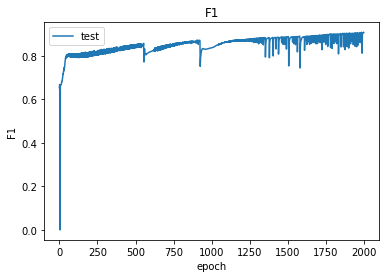

In [7]:
plt.plot(history.history['f1_m'])
#plt.plot(history.history['val_acc'])
plt.title('F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

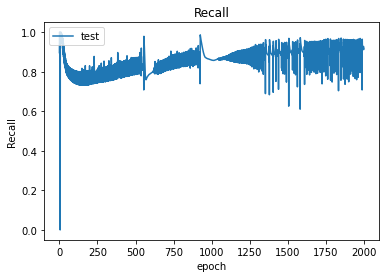

In [8]:
plt.plot(history.history['recall_m'])
#plt.plot(history.history['val_acc'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['test', 'val'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(3,130),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf1 = RandomForestClassifier(random_state=25,n_jobs=-1)

clf2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__criterion'] = ["gini", "entropy"]
param1['classifier__max_depth'] = [40,80]
param1['classifier__min_samples_split'] = [130]
param1['classifier__min_samples_leaf'] = [40]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier'] = [clf2]



pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2]



rf_random = RandomizedSearchCV(pipeline, param_distributions=params,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')
                                   #n_iter=5,cv=5,scoring=['f1','balanced_accuracy','precision','recall','roc_auc'],random_state=25,return_train_score=True,refit='f1')

rf_random.fit(df_final_train,y_train)
print('mean test f1',rf_random.cv_results_['mean_test_f1'])
print('mean train f1',rf_random.cv_results_['mean_train_f1'])

[18:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:25:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:25:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [10]:
rf_random.cv_results_

{'mean_fit_time': array([ 7.9623734 ,  0.67824521,  0.66614056,  8.1472301 ,  8.39777279,
         2.40228271,  1.99749269,  1.7210196 , 15.26790929,  0.61977878]),
 'std_fit_time': array([1.04690829, 0.08925616, 0.09109784, 0.7057037 , 0.70087508,
        0.27088536, 0.15318134, 0.04957571, 0.73837605, 0.04028144]),
 'mean_score_time': array([0.34275646, 0.07054238, 0.08508935, 0.41004467, 0.49464688,
        0.15651035, 0.15014534, 0.10479975, 0.11715765, 0.05824113]),
 'std_score_time': array([0.00935022, 0.00635427, 0.01596334, 0.08832891, 0.23068506,
        0.03781918, 0.01365776, 0.00315172, 0.01998916, 0.00440892]),
 'param_classifier__n_estimators': masked_array(data=[250, 10, 10, 250, 250, 50, 50, 50, --, 10],
              mask=[False, False, False, False, False, False, False, False,
                     True, False],
        fill_value='?',
             dtype=object),
 'param_classifier__min_samples_split': masked_array(data=[130, 130, 130, 130, 130, 130, 130, 130, --, 130]

In [11]:
print(rf_random.best_estimator_)
rf_random.best_params_

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])


{'classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=109, n_jobs=4,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)}

In [12]:
pd.DataFrame(rf_random.cv_results_)['params']

0    {'classifier__n_estimators': 250, 'classifier_...
1    {'classifier__n_estimators': 10, 'classifier__...
2    {'classifier__n_estimators': 10, 'classifier__...
3    {'classifier__n_estimators': 250, 'classifier_...
4    {'classifier__n_estimators': 250, 'classifier_...
5    {'classifier__n_estimators': 50, 'classifier__...
6    {'classifier__n_estimators': 50, 'classifier__...
7    {'classifier__n_estimators': 50, 'classifier__...
8    {'classifier': XGBClassifier(base_score=0.5, b...
9    {'classifier__n_estimators': 10, 'classifier__...
Name: params, dtype: object

In [13]:
rf_pd=pd.DataFrame(rf_random.cv_results_)
rf_pd = rf_pd.set_index(rf_pd["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
list(rf_pd.params)

[{'classifier__n_estimators': 250,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 80,
  'classifier__criterion': 'entropy',
  'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
 {'classifier__n_estimators': 10,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 80,
  'classifier__criterion': 'entropy',
  'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
 {'classifier__n_estimators': 10,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 40,
  'classifier__criterion': 'gini',
  'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
 {'classifier__n_estimators': 250,
  'classifier__min_samples_split': 130,
  'classifier__min_samples_leaf': 40,
  'classifier__max_depth': 40,
  'classifier__criterion': 'gini',
  'classifier': RandomForestClassifier(n_jobs=-1, random_state=25)},
 {'c

In [14]:
rf_pd[["params"]]

,params
params,
"250_130_40_80_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 250, 'classifier_..."
"10_130_40_80_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 10, 'classifier__..."
"10_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 10, 'classifier__..."
"250_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 250, 'classifier_..."
"250_130_40_40_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 250, 'classifier_..."
"50_130_40_40_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 50, 'classifier__..."
"50_130_40_80_gini_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 50, 'classifier__..."
"50_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 50, 'classifier__..."
"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=109, n_jobs=4,\n num_parallel_tree=1, predictor='auto', random_state=0,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n tree_method='exact', validate_parameters=1, verbosity=None)","{'classifier': XGBClassifier(base_score=0.5, b..."


In [15]:
names=rf_pd.params

## Barplot for each model in every slit for recall

The score for the first split with each parameter


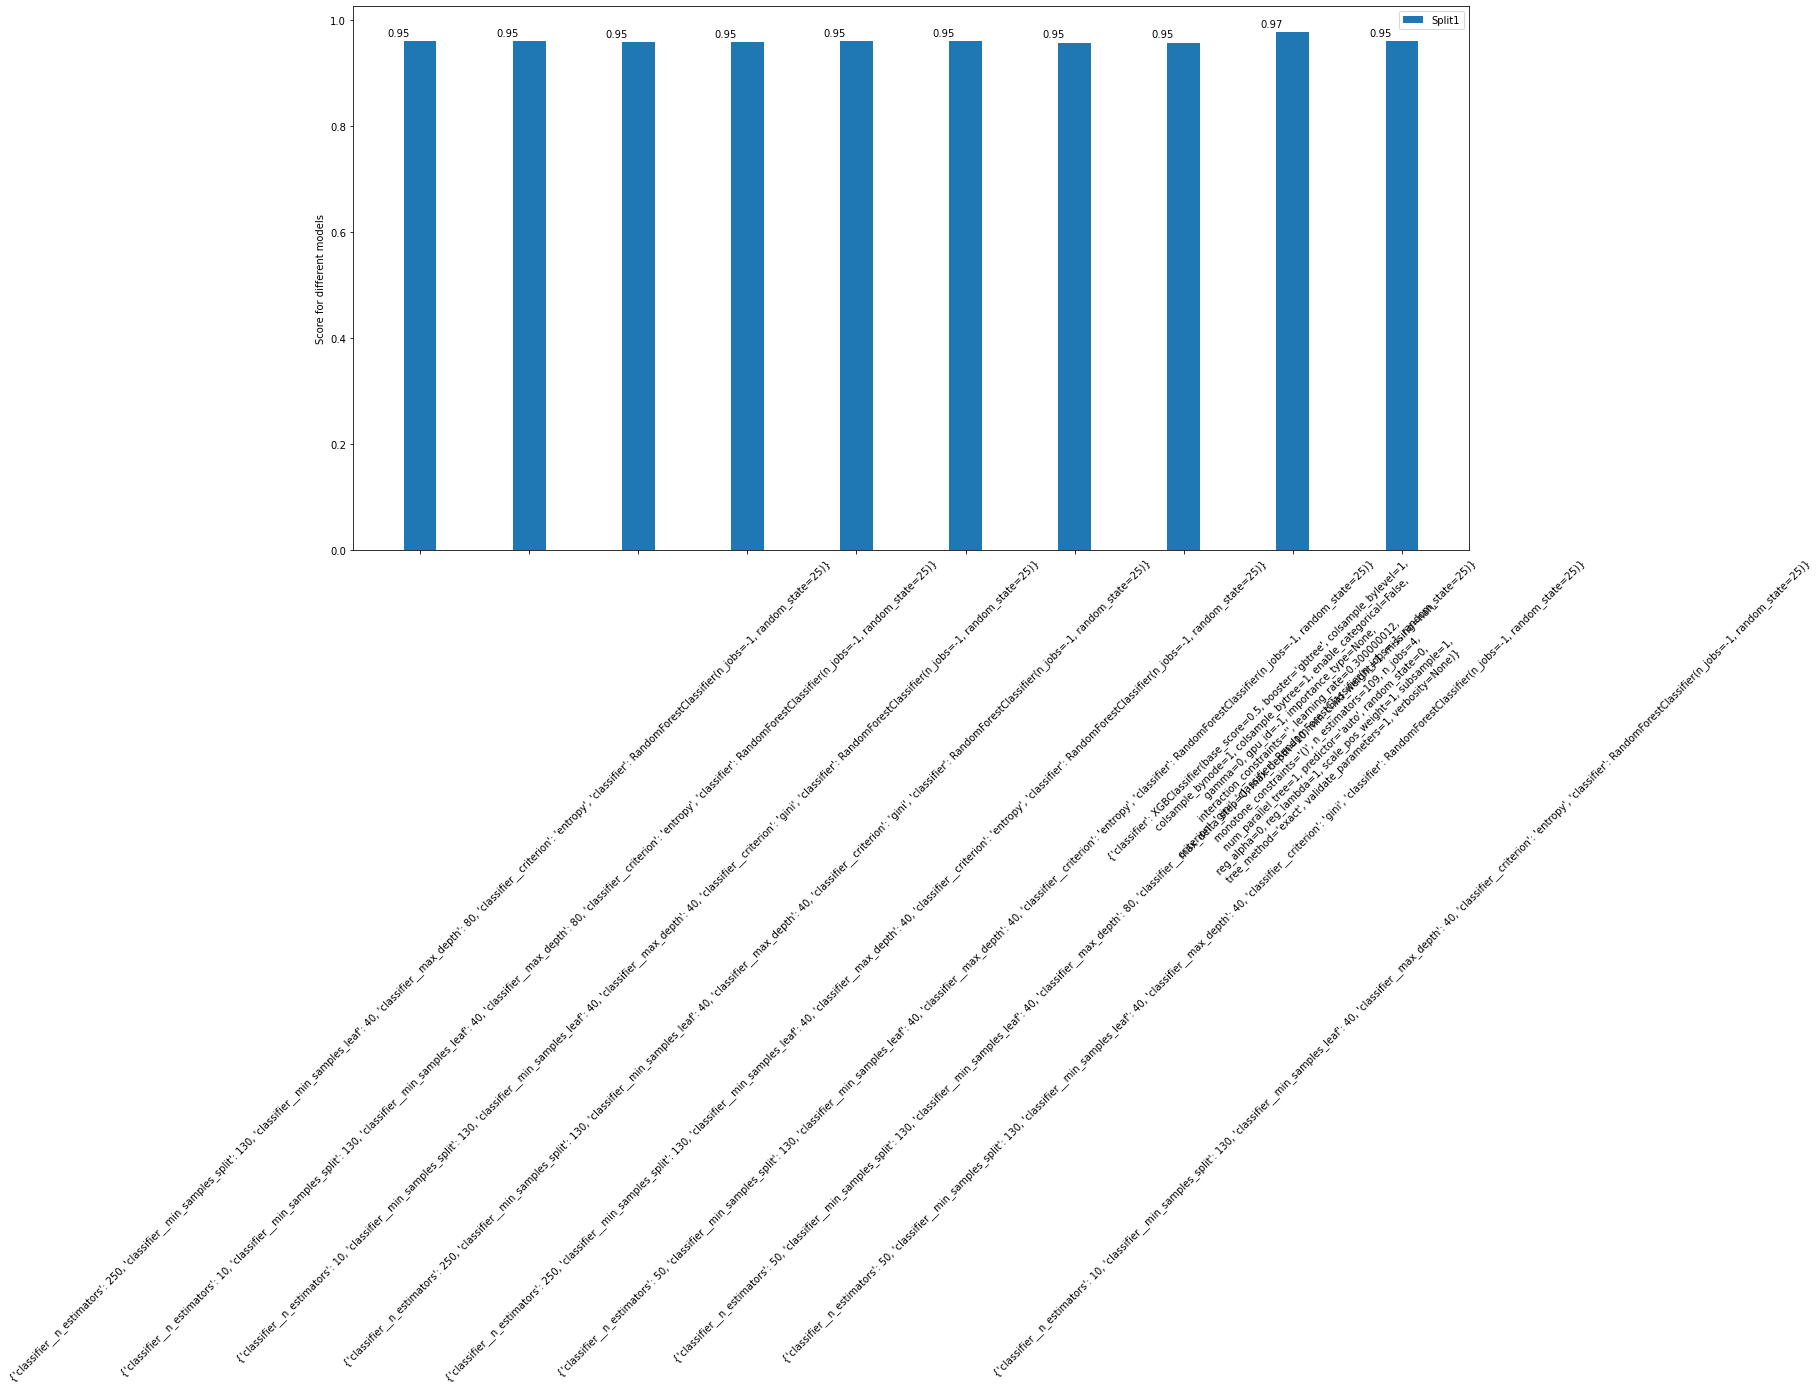

The score for the second split with each parameter


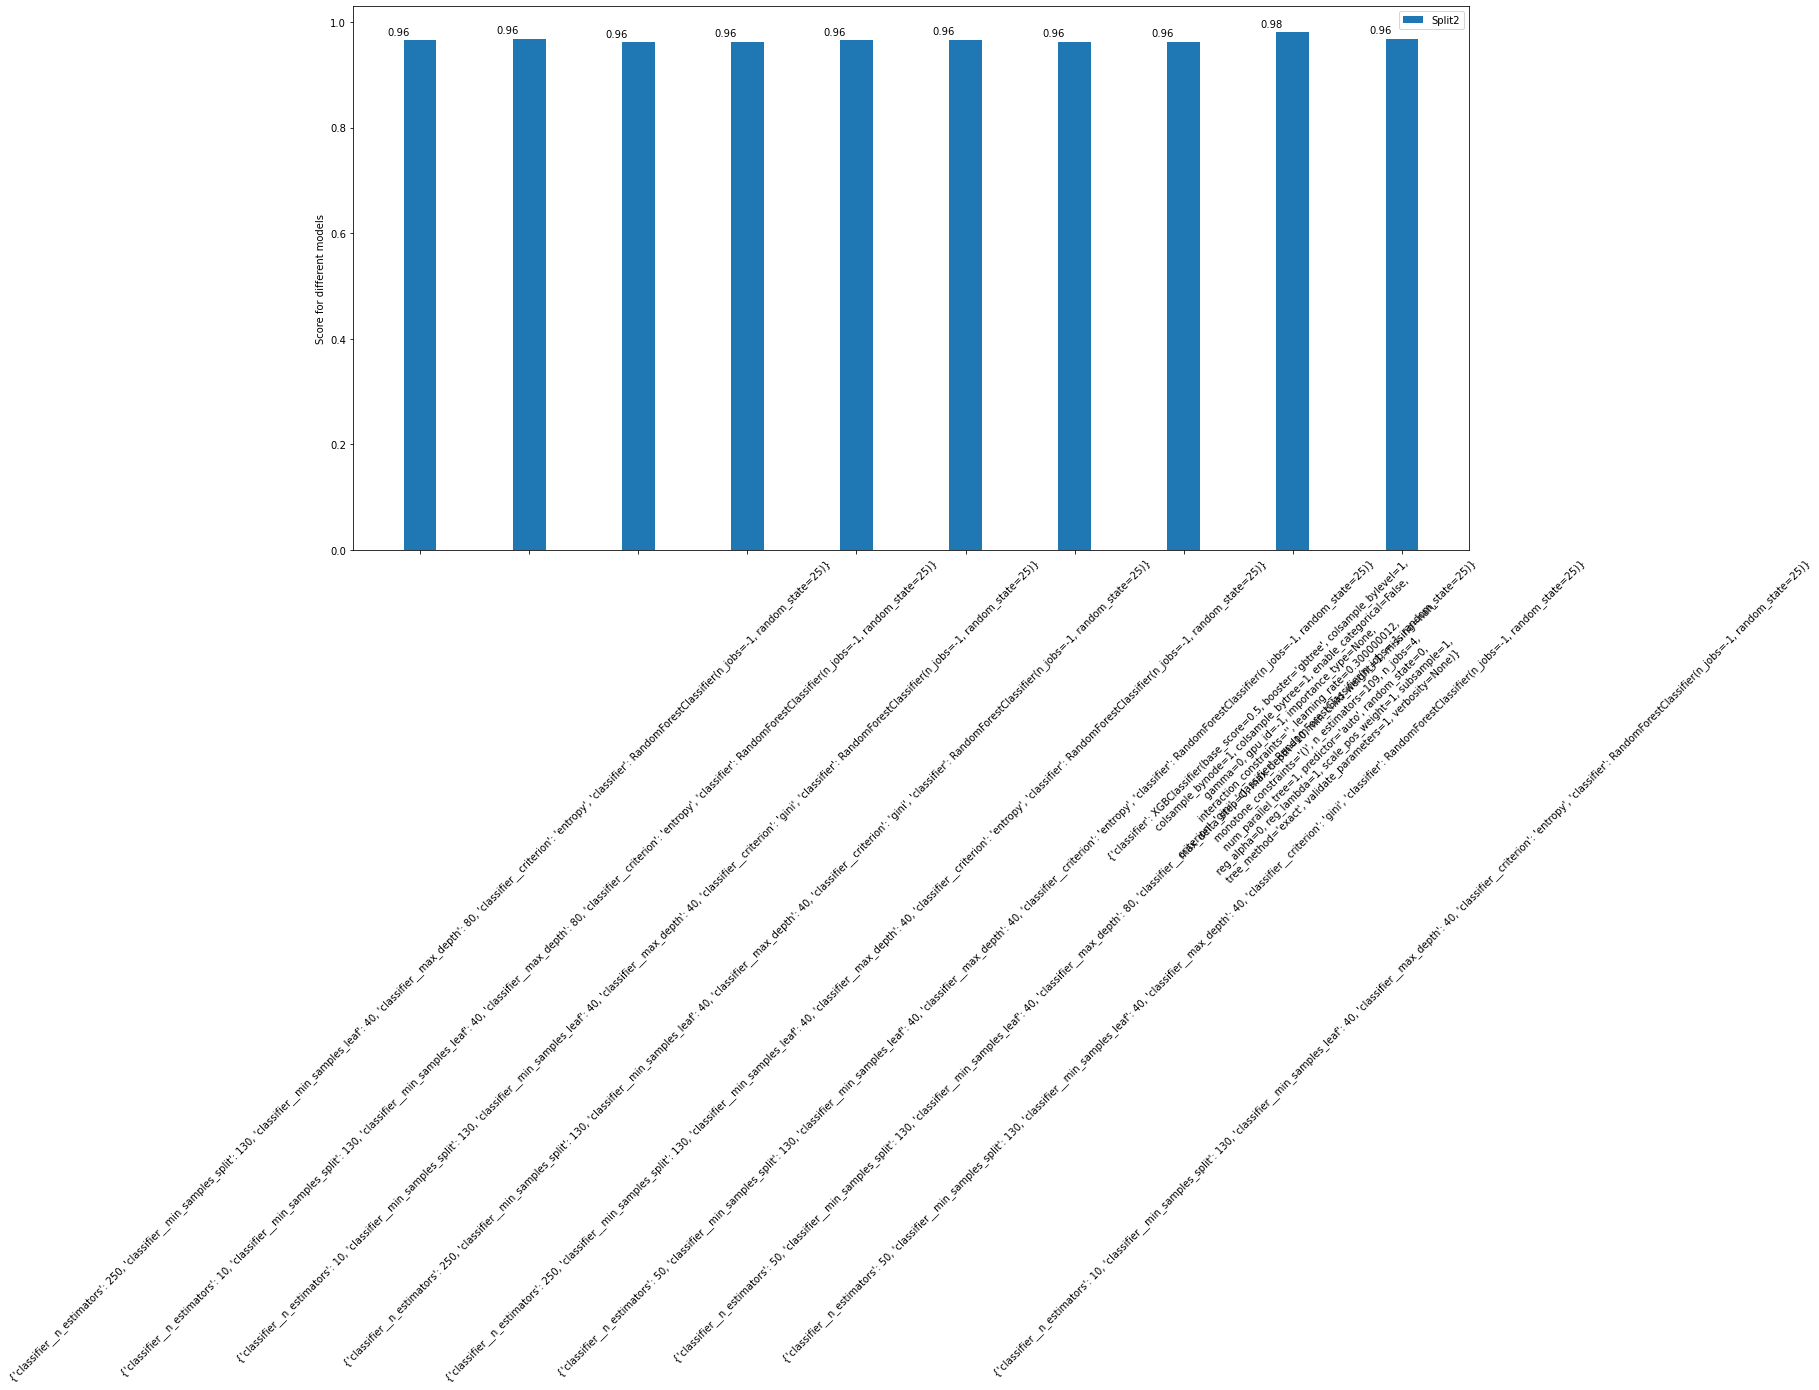

The score for the third split with each parameter


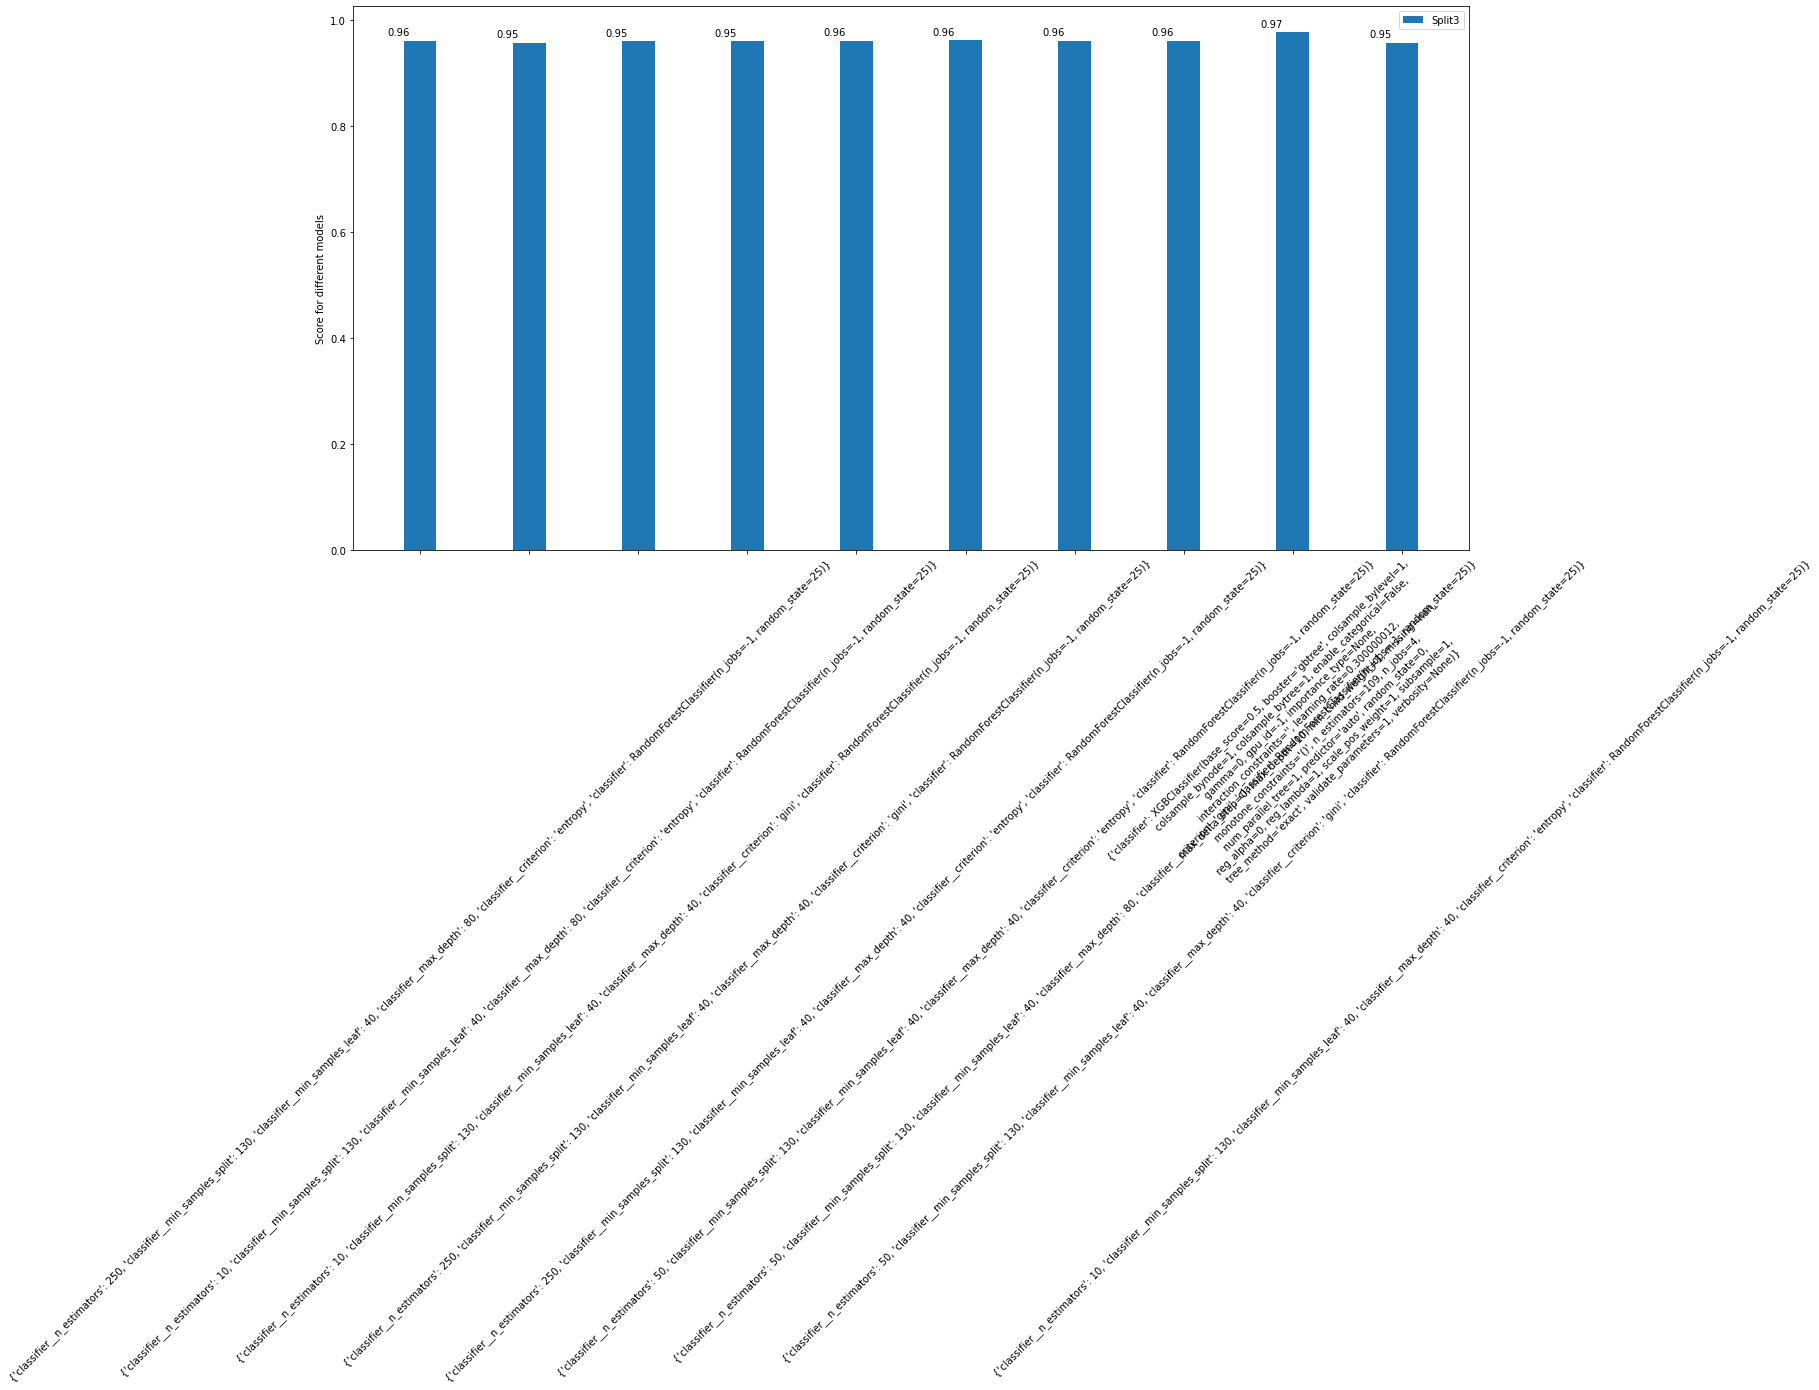

The score for the fouth split with each parameter


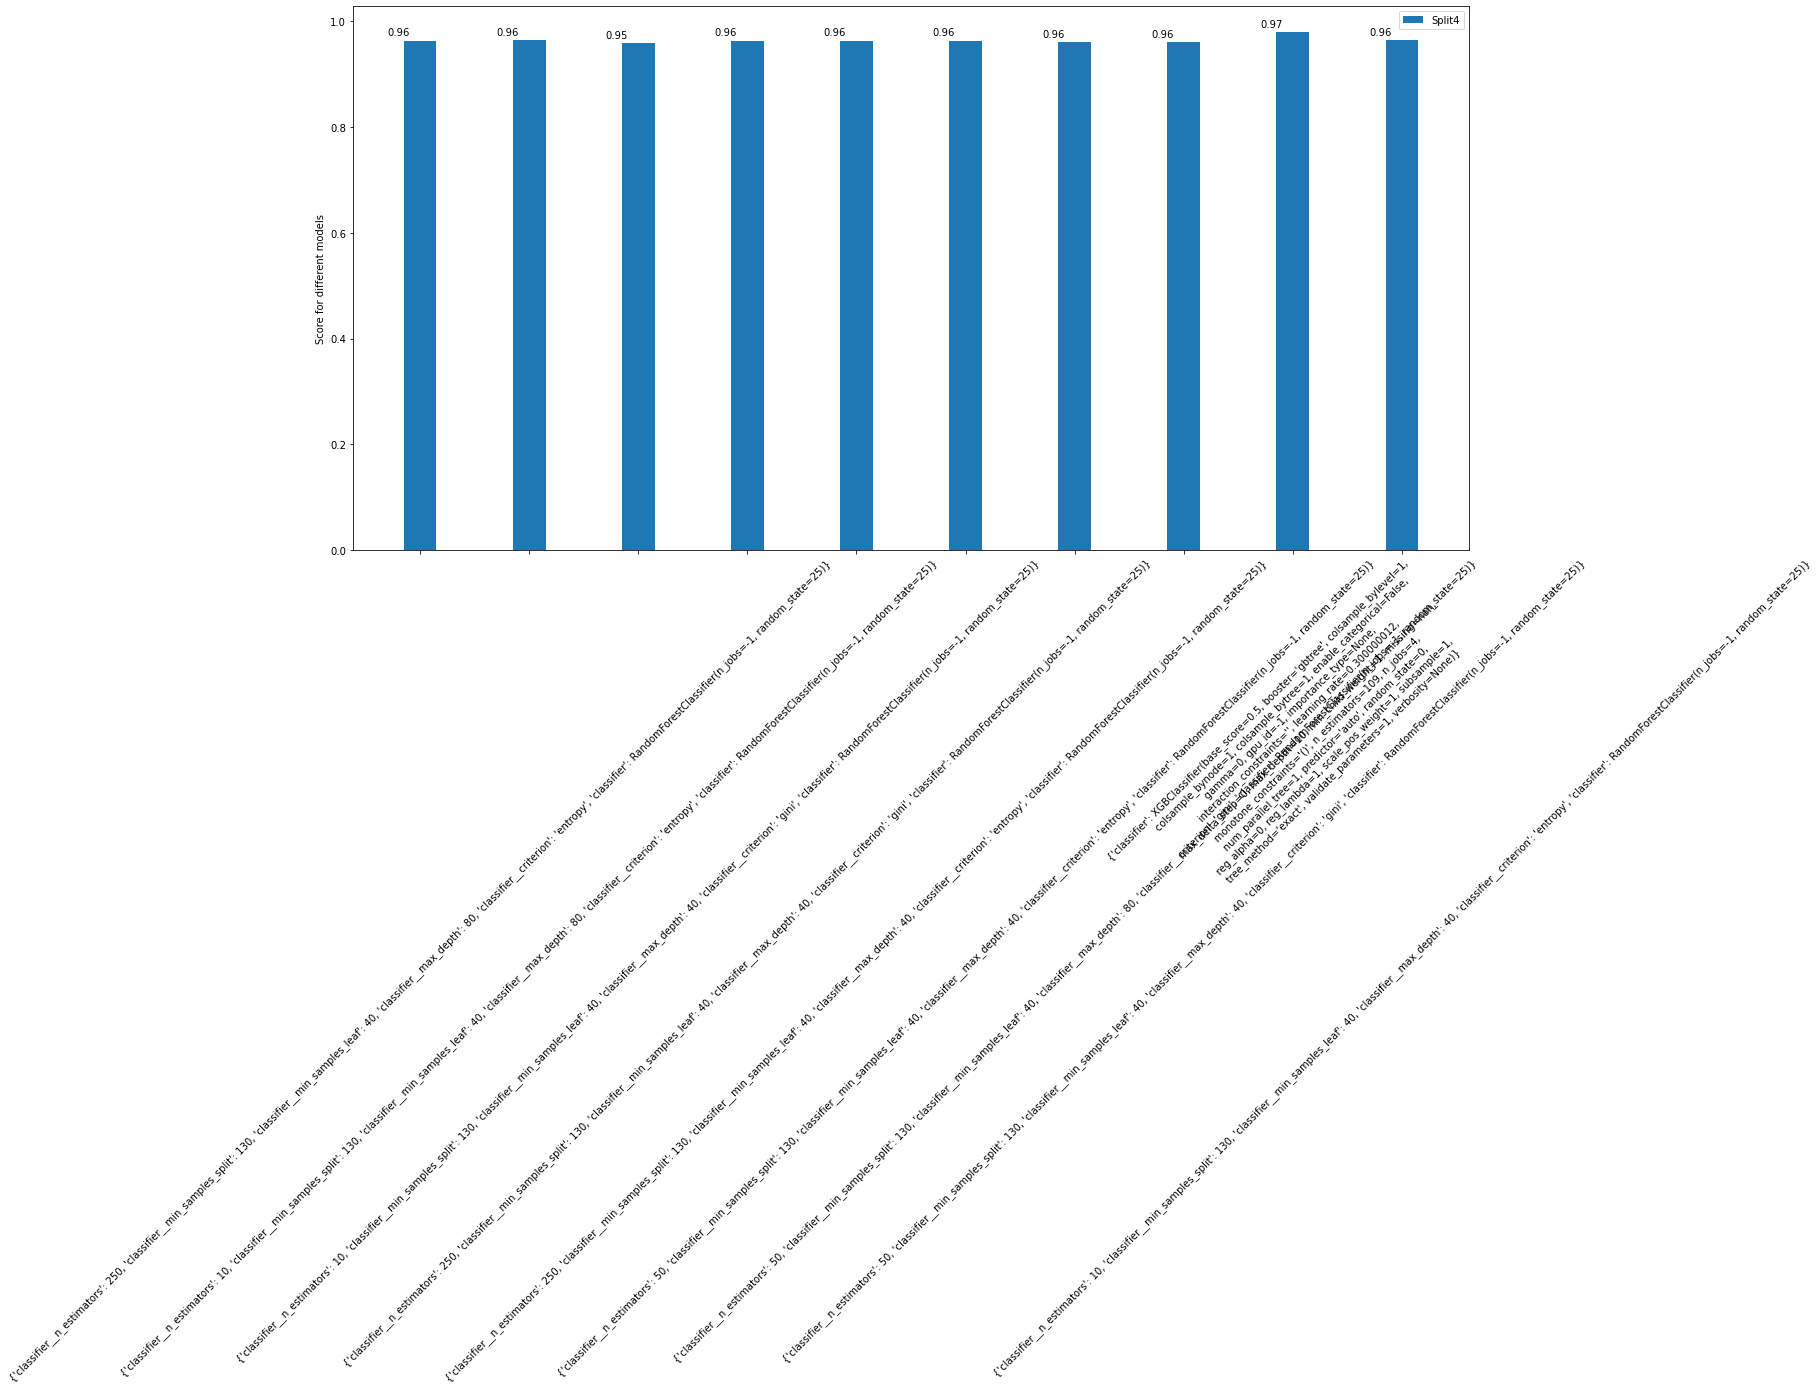

The score for the fifth split with each parameter


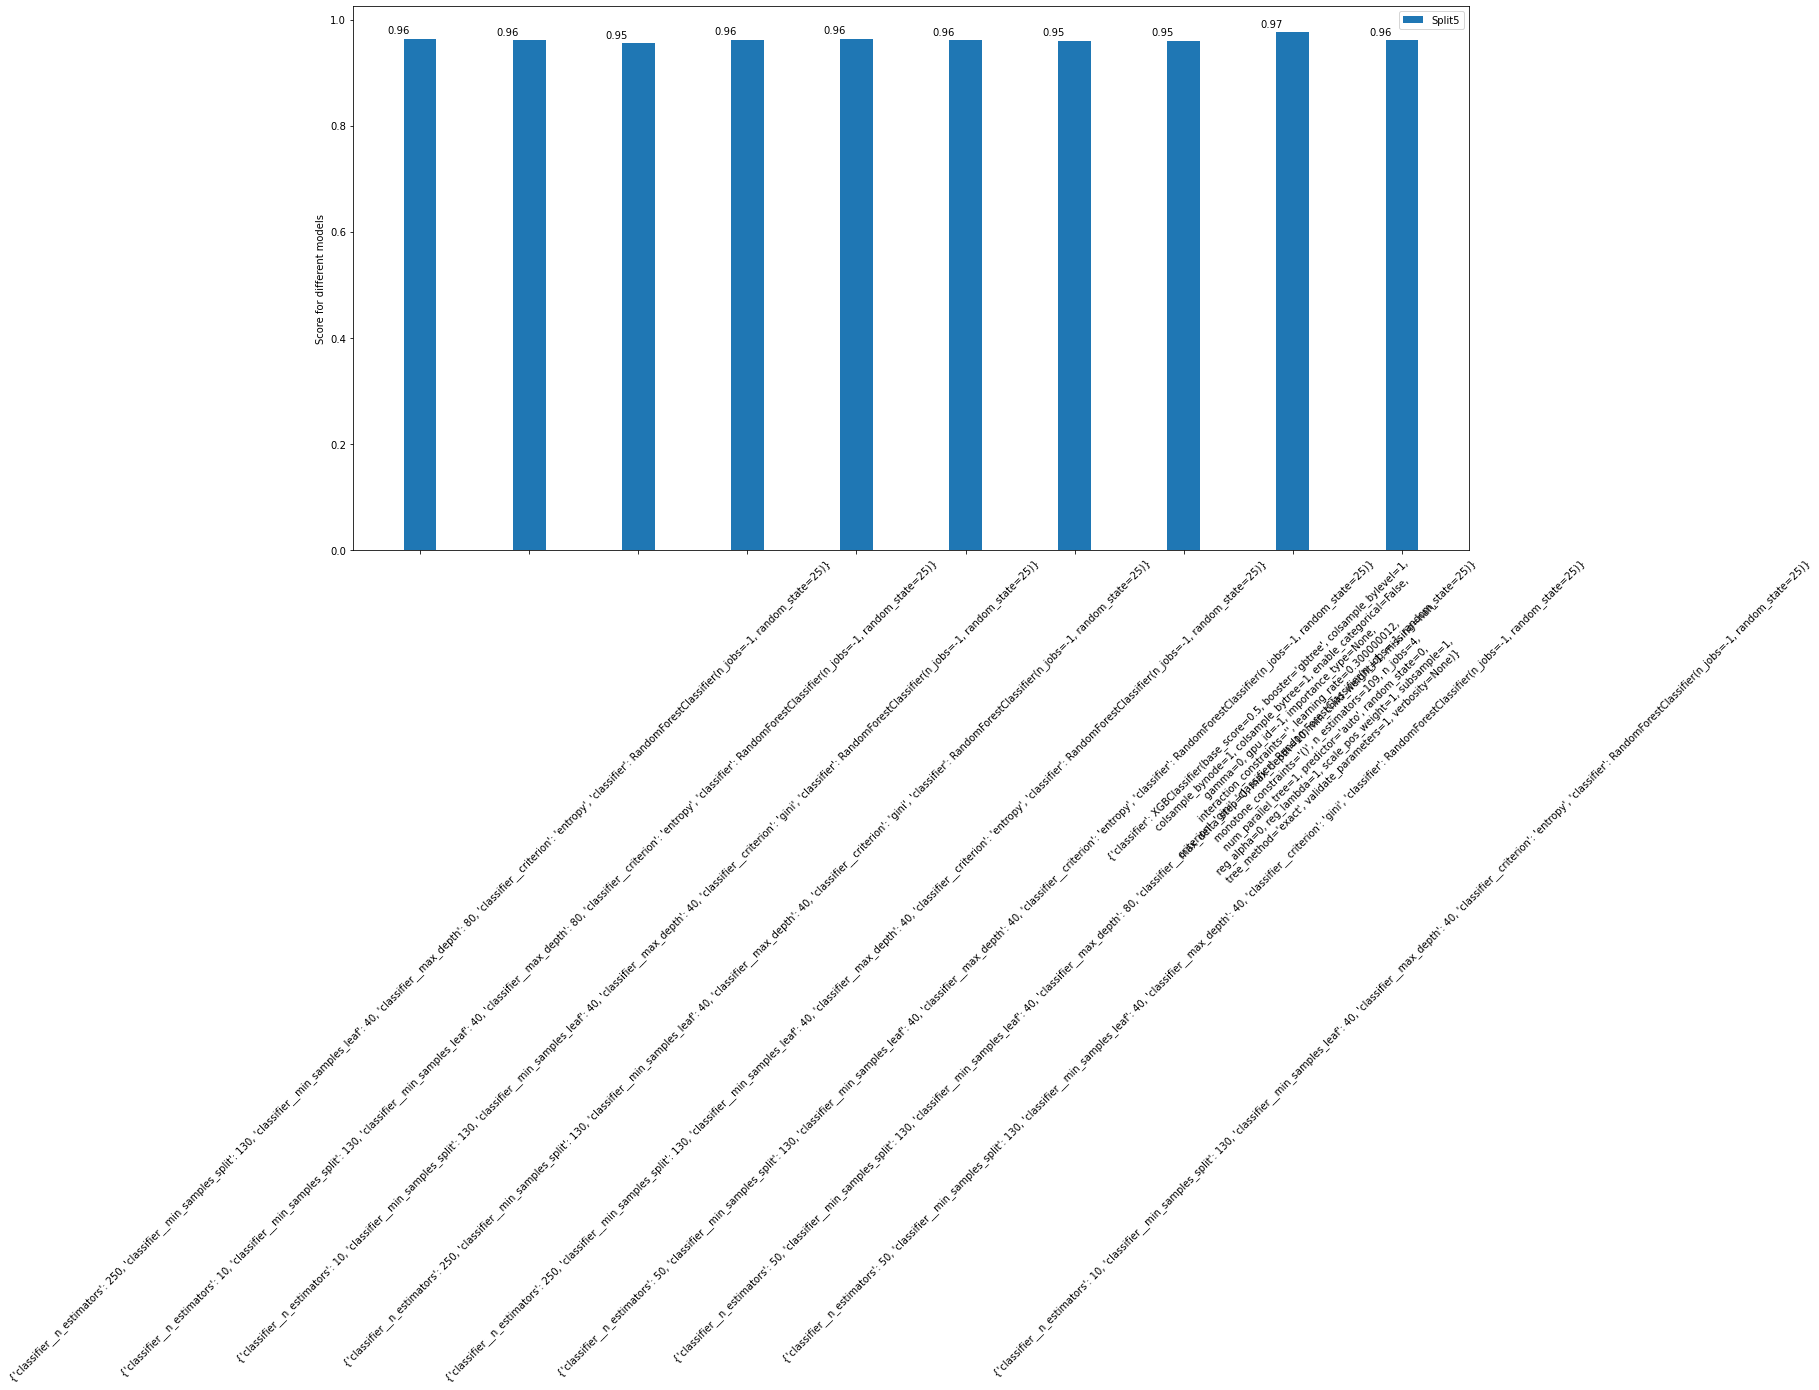

In [16]:
x = np.arange(len(pd.DataFrame(rf_random.cv_results_)["split0_test_recall"]))

print("The score for the first split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split0_test_recall"], width, label='Split1')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split0_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the second split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split1_test_recall"], width, label='Split2')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split1_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the third split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split2_test_recall"], width, label='Split3')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split2_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fouth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split3_test_recall"], width, label='Split4')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split3_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fifth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split4_test_recall"], width, label='Split5')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split4_test_recall"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()


## Barplot for each model in every slit for f1

The score for the first split with each parameter


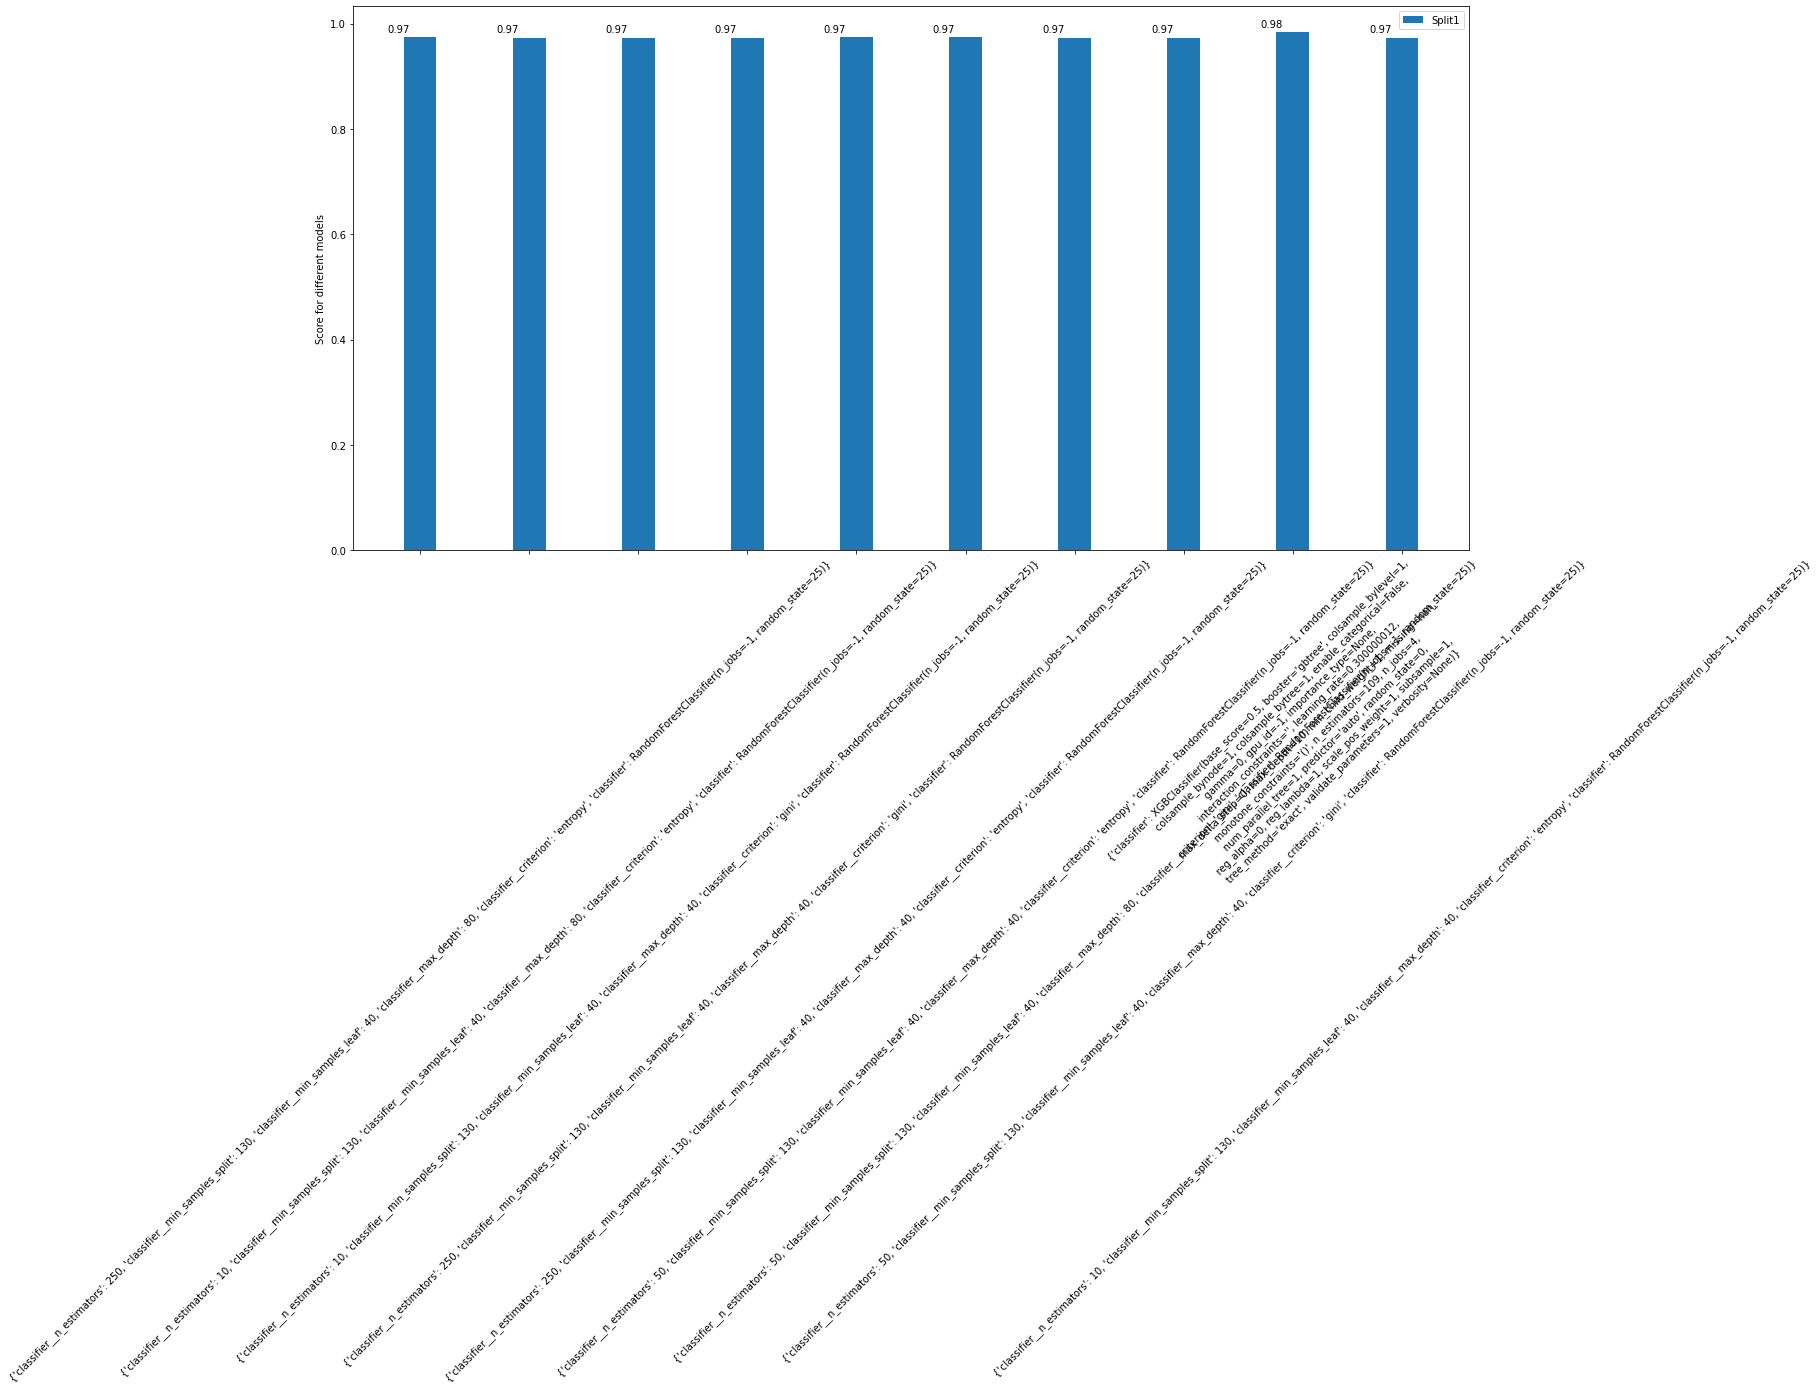

The score for the second split with each parameter


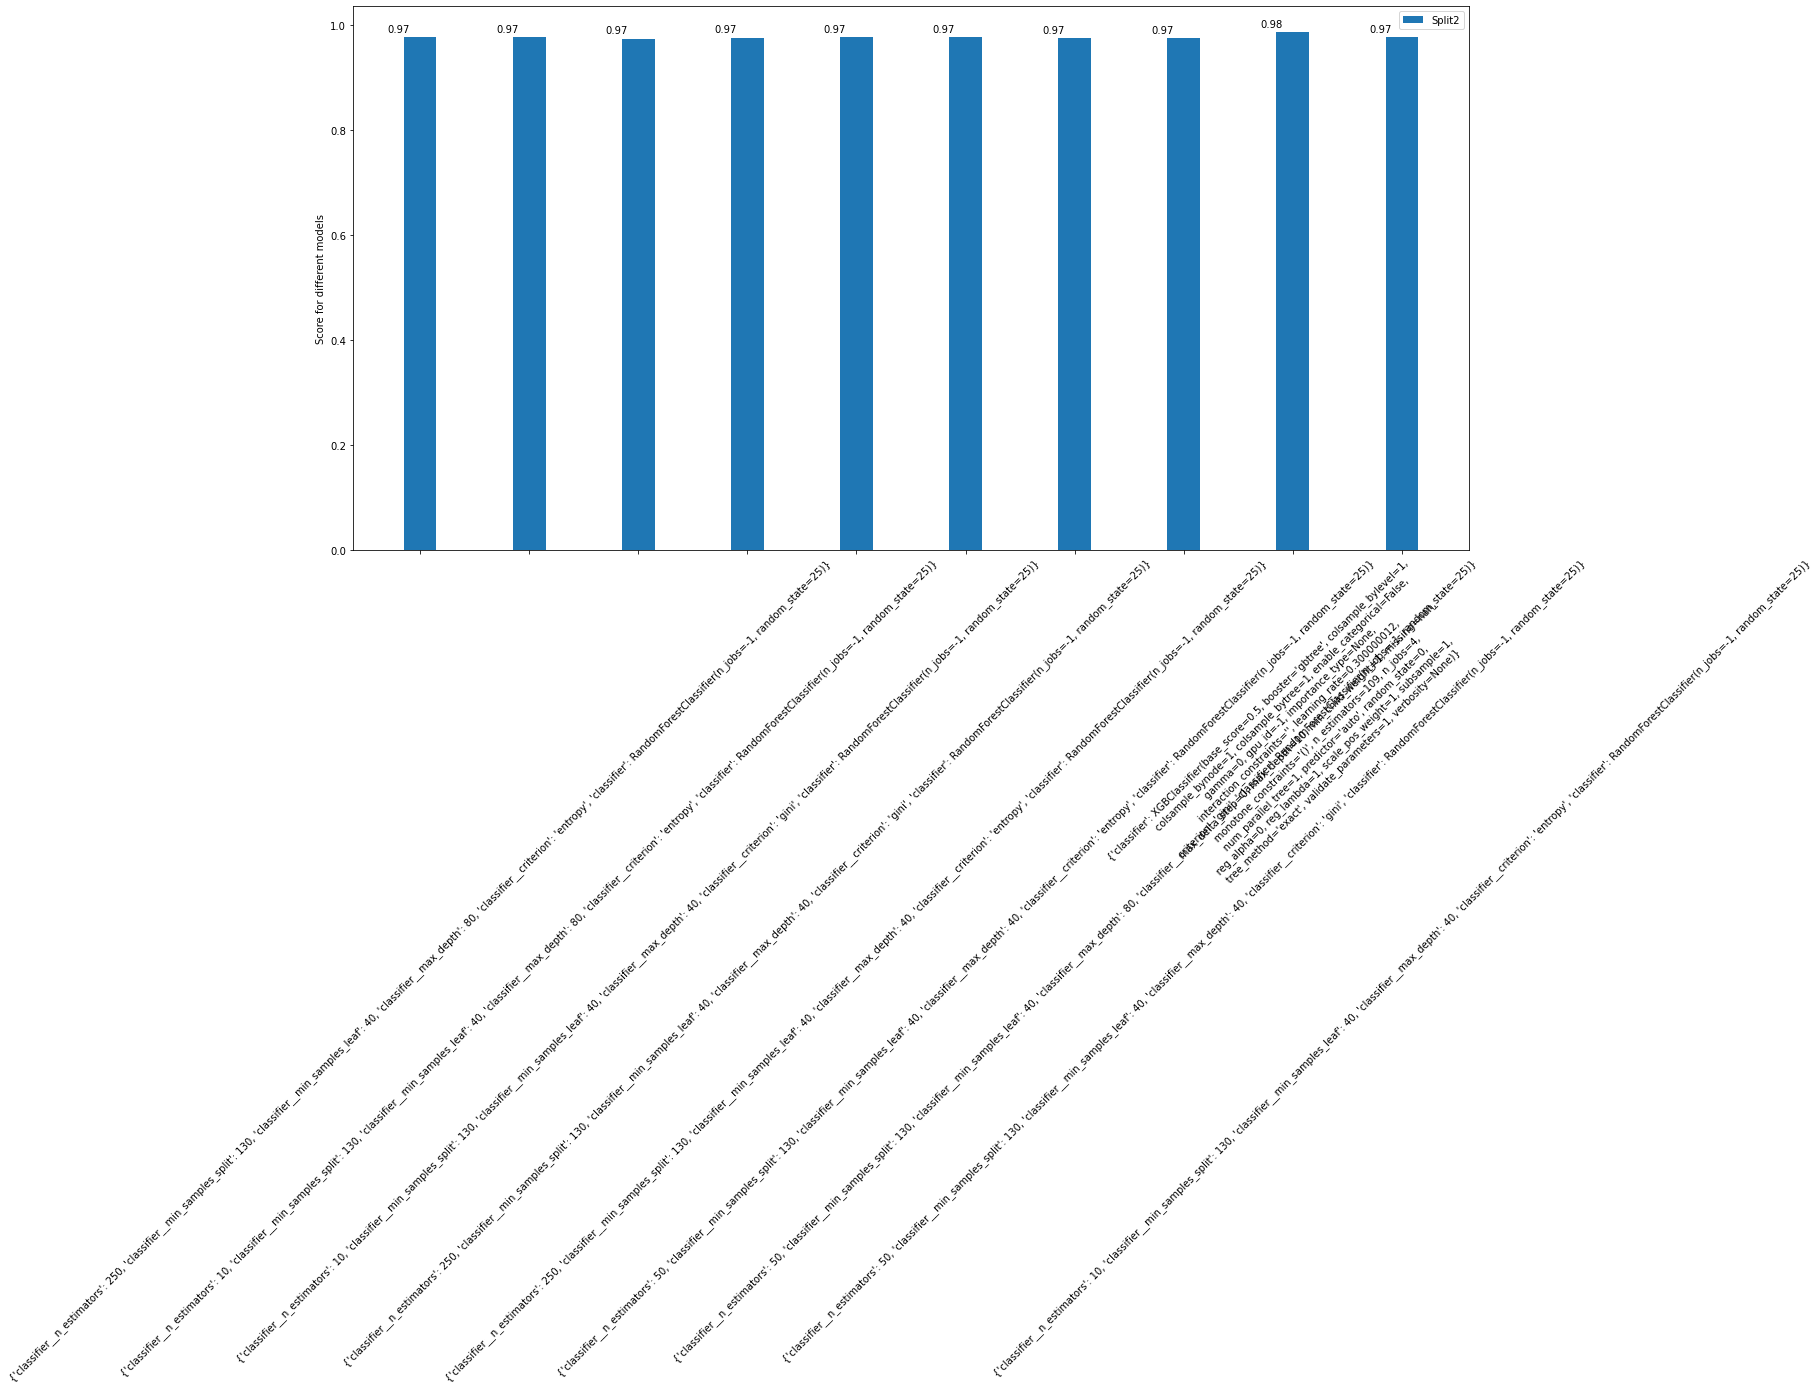

The score for the third split with each parameter


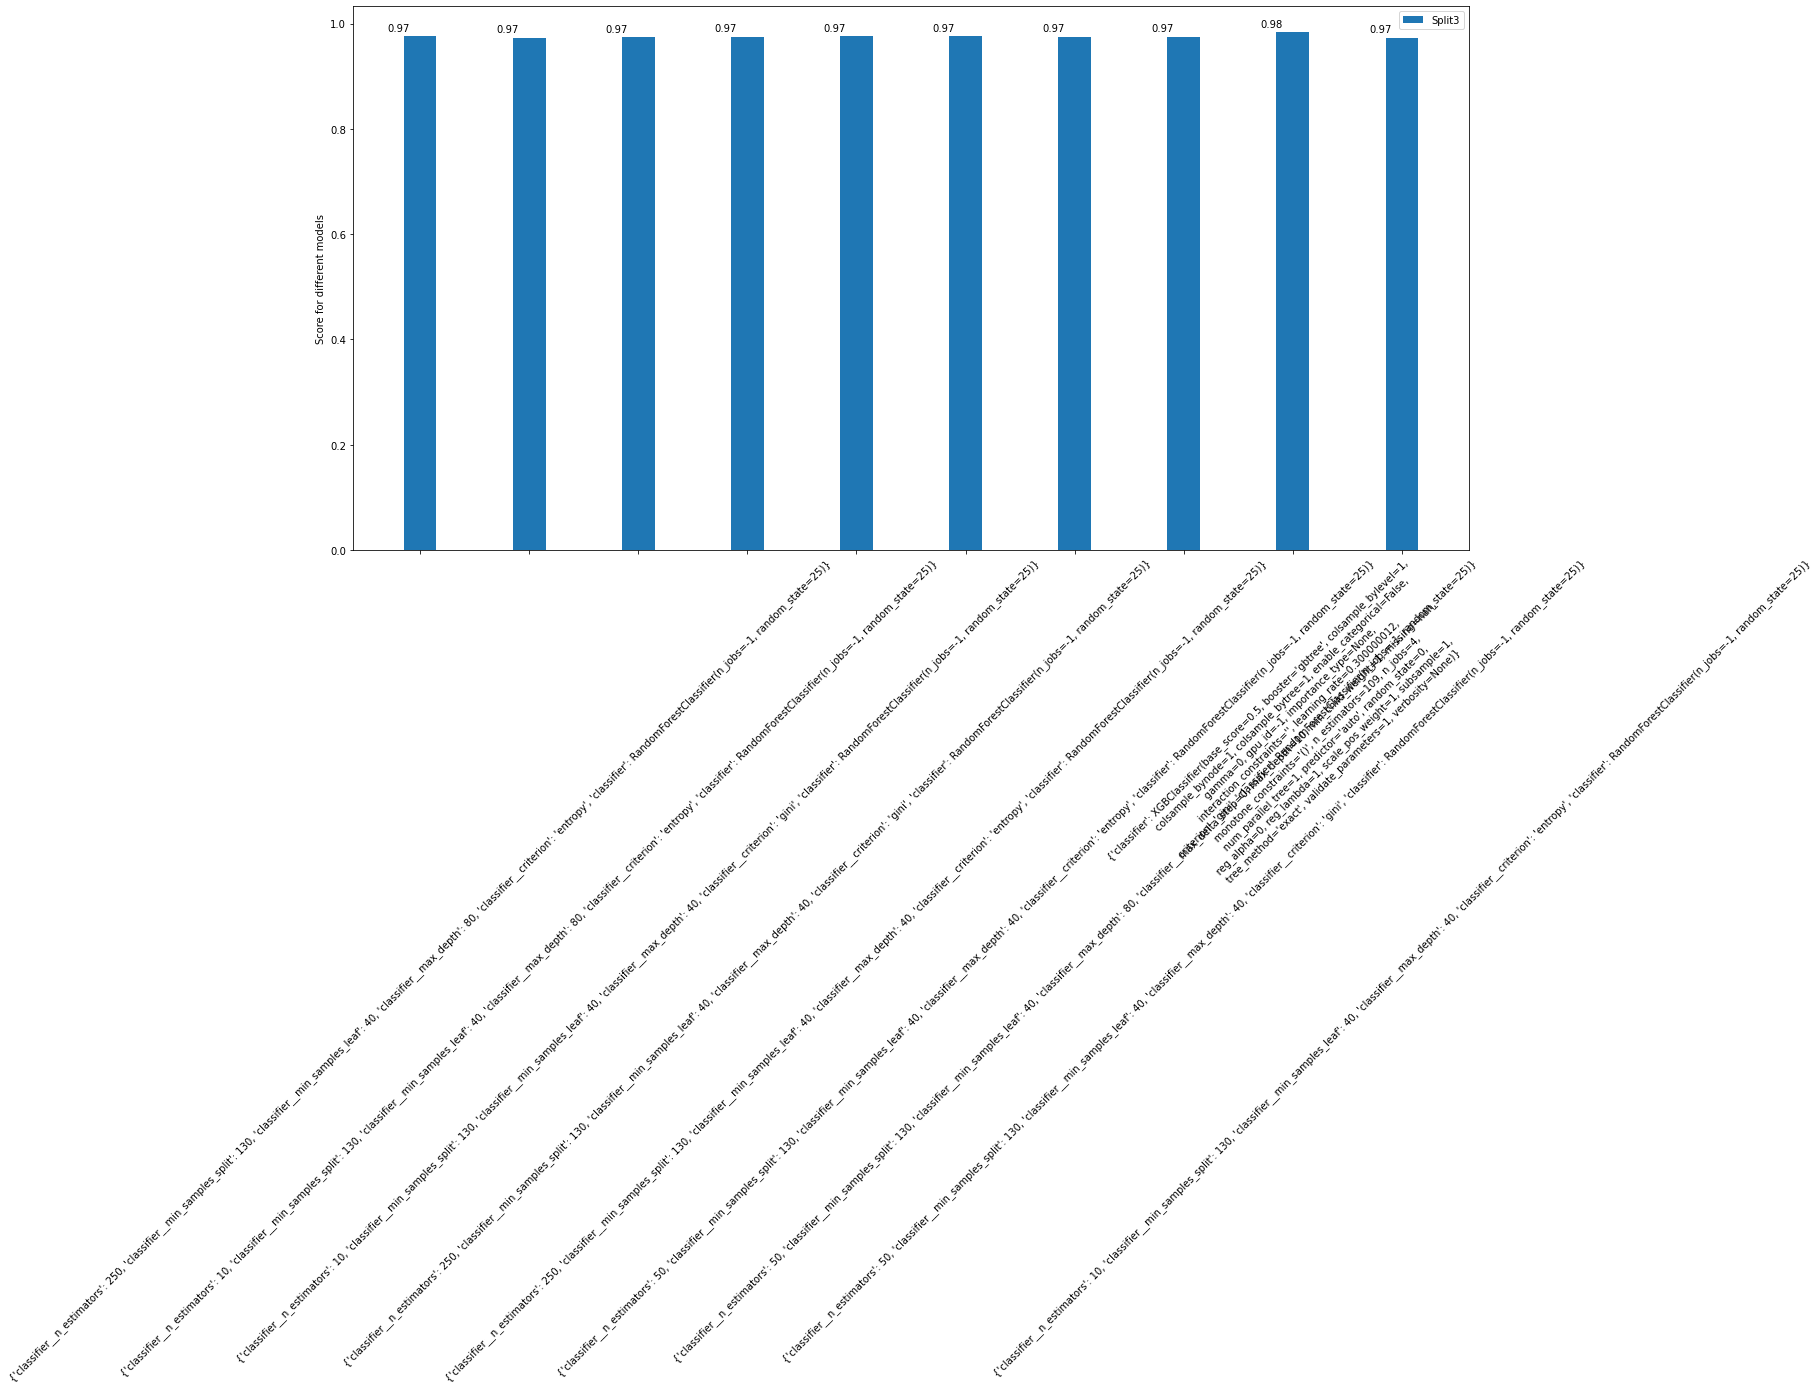

The score for the fouth split with each parameter


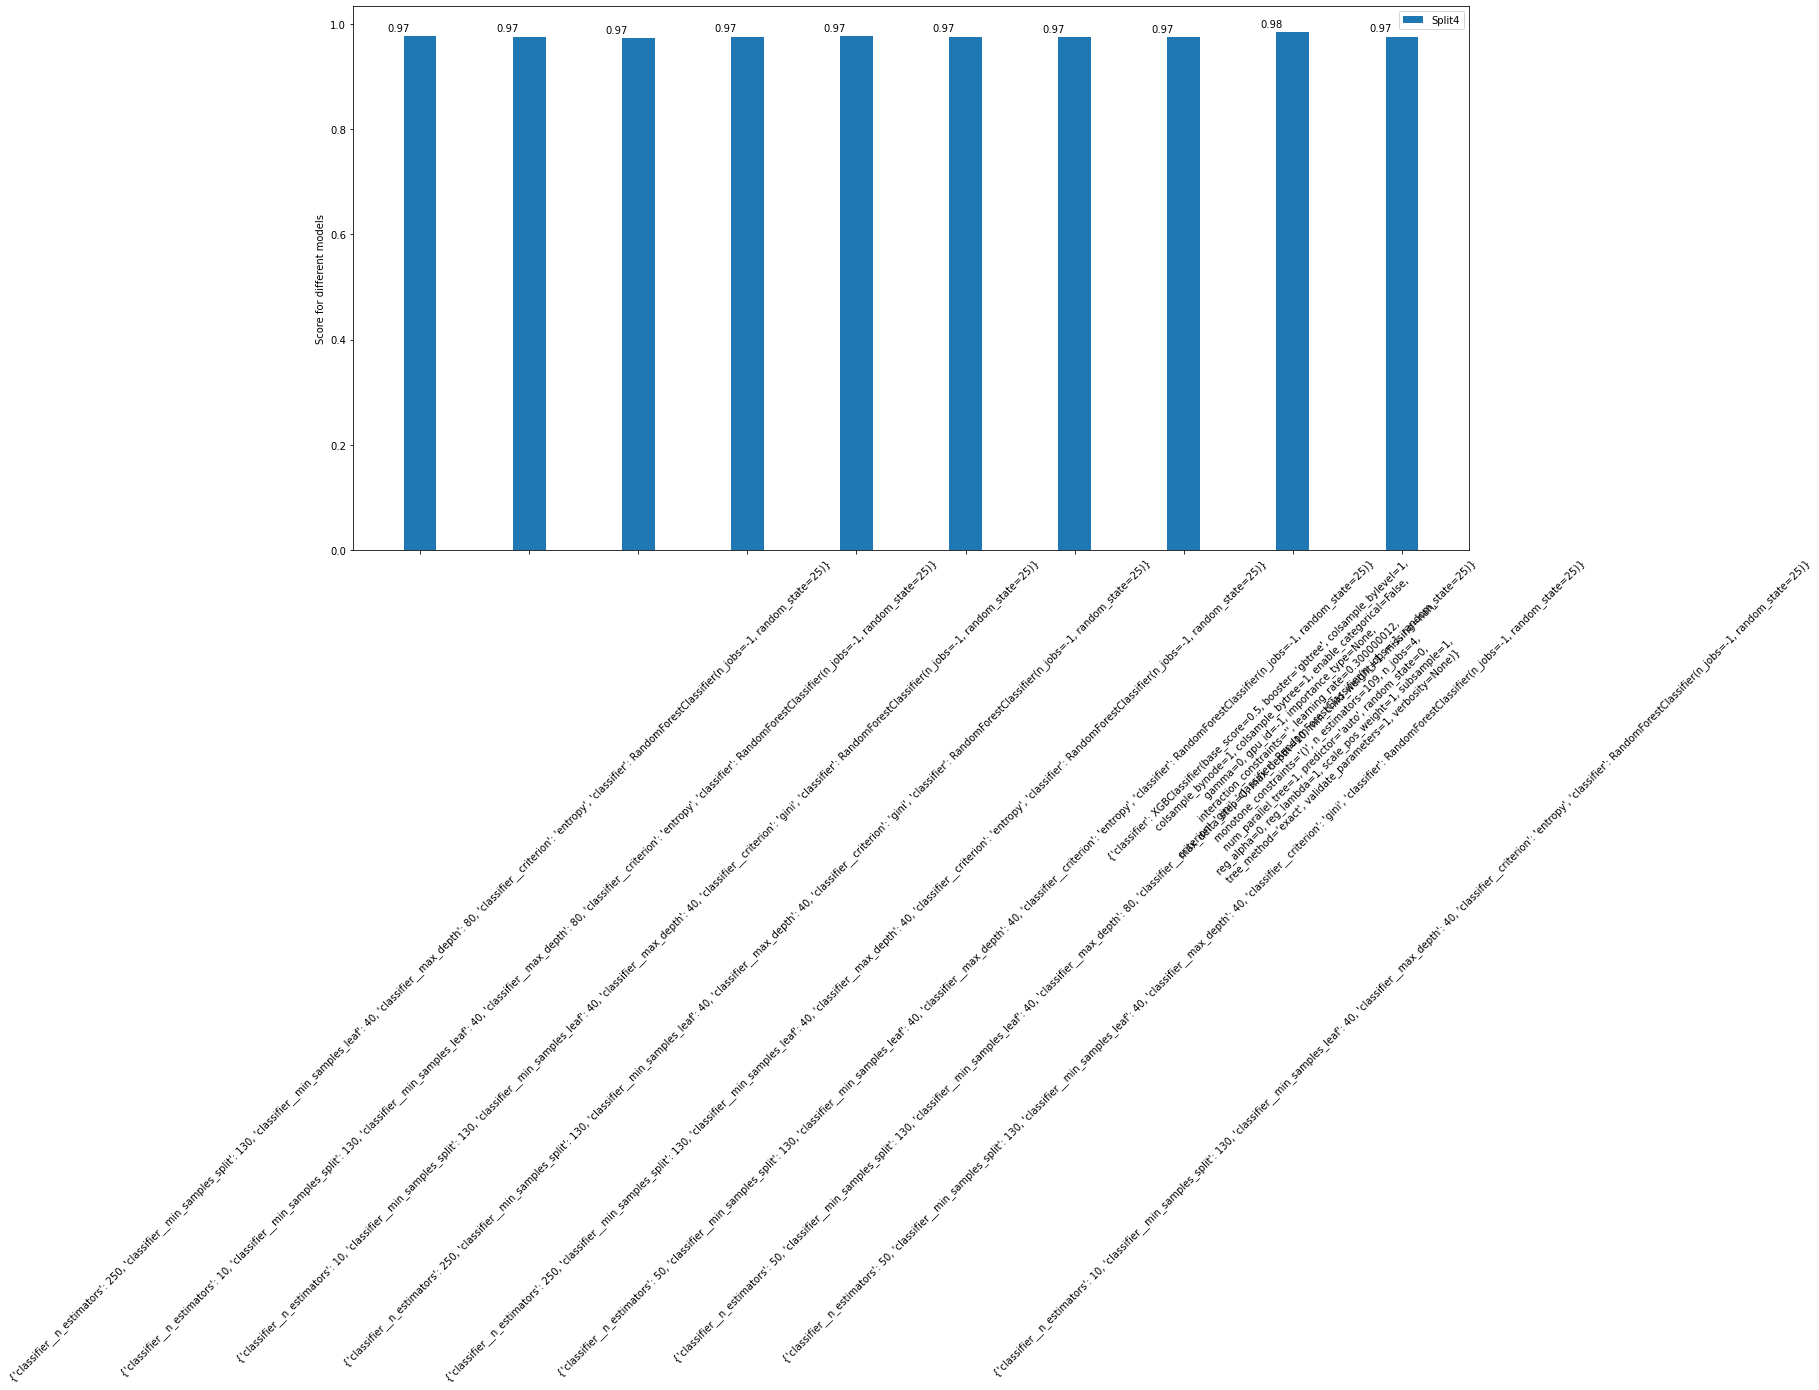

The score for the fifth split with each parameter


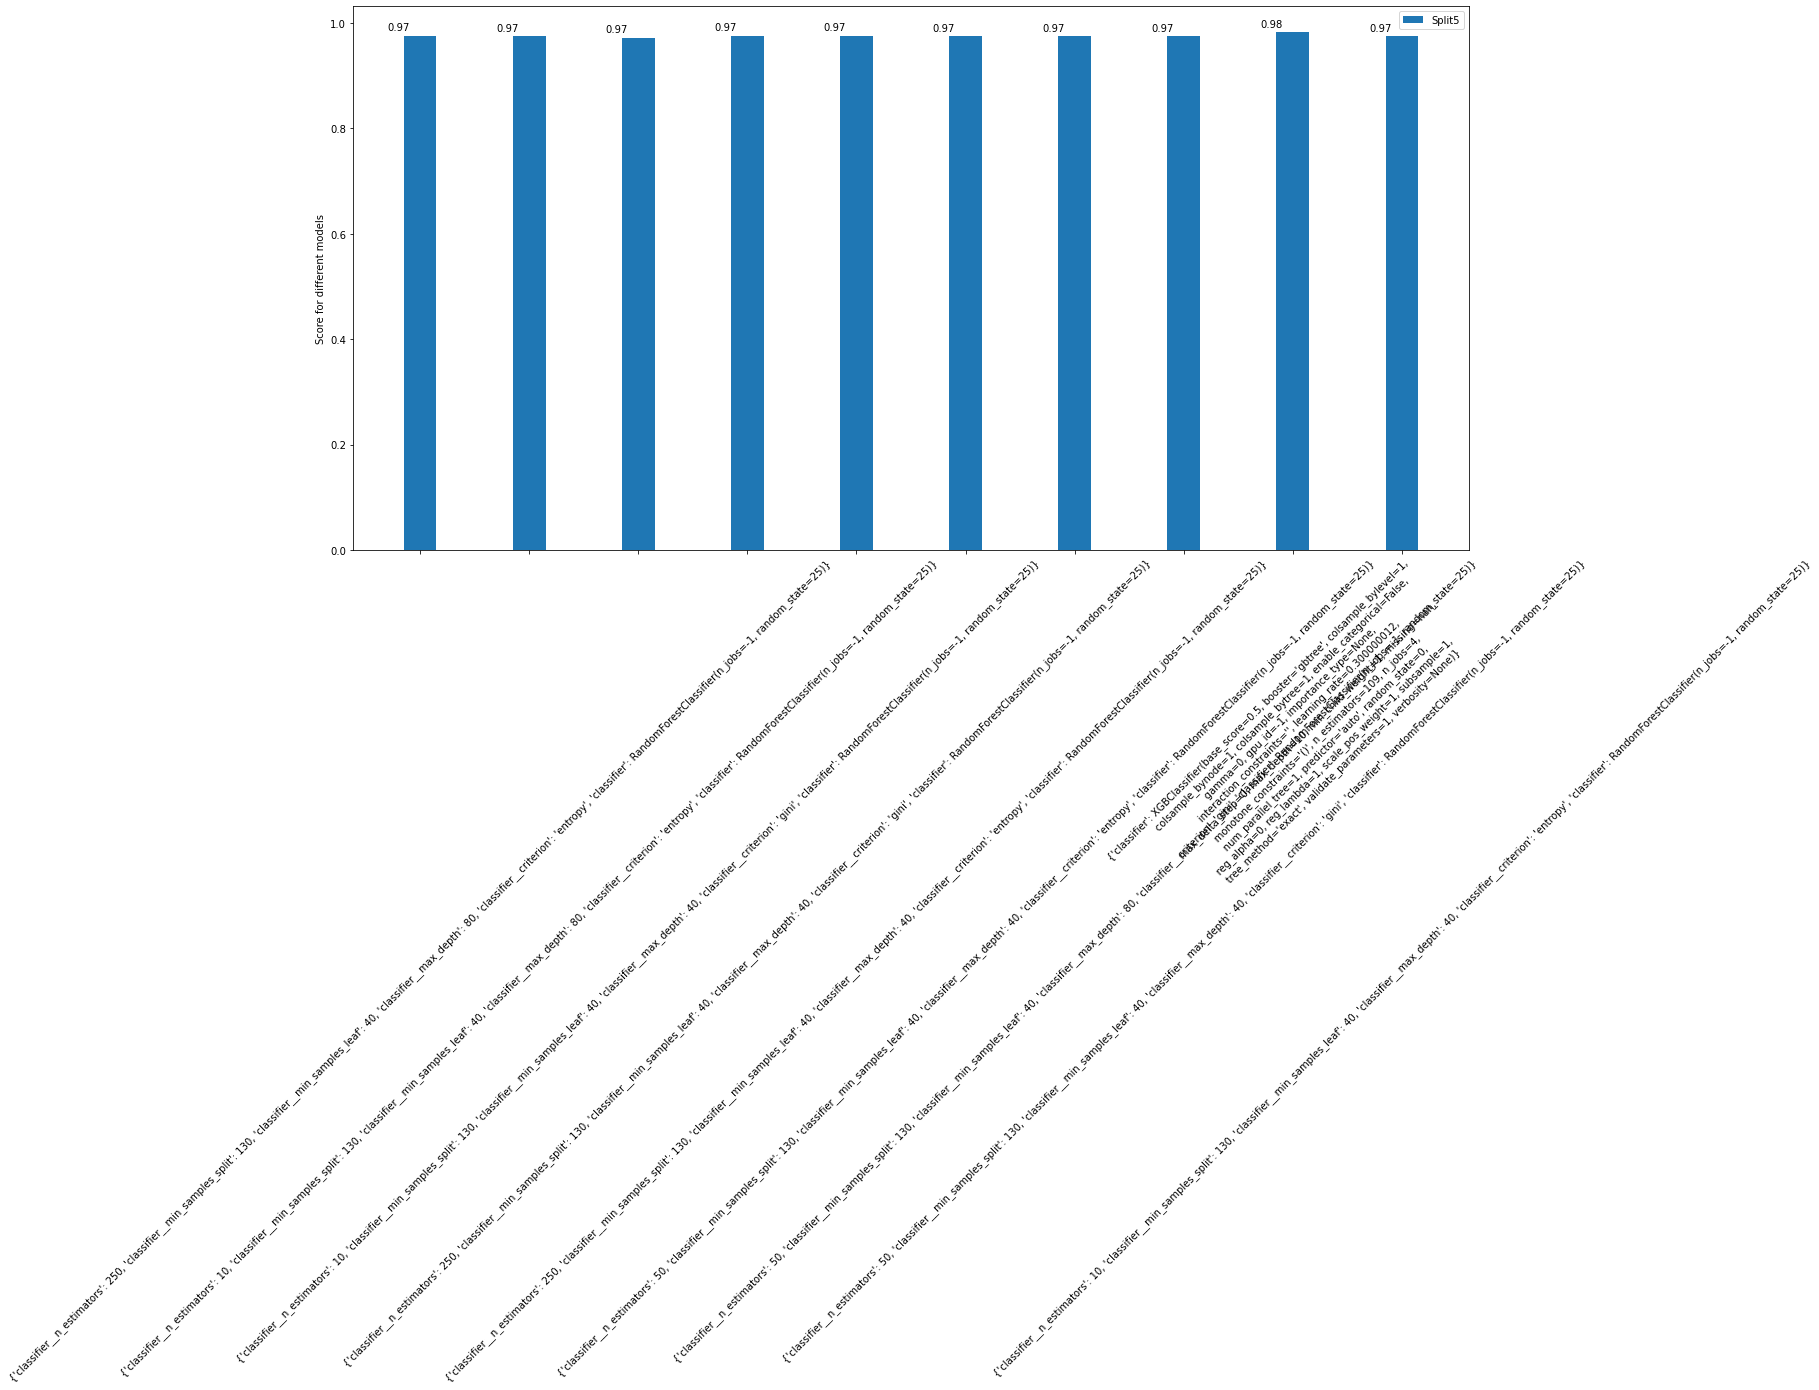

In [17]:
x = np.arange(len(pd.DataFrame(rf_random.cv_results_)["split0_test_f1"]))

print("The score for the first split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split0_test_f1"], width, label='Split1')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split0_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the second split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split1_test_f1"], width, label='Split2')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split1_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the third split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split2_test_f1"], width, label='Split3')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split2_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fouth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split3_test_f1"], width, label='Split4')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split3_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()

print("The score for the fifth split with each parameter")
width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x, pd.DataFrame(rf_random.cv_results_)["split4_test_f1"], width, label='Split5')
plt.xticks(ticks=x, labels=names,rotation=45)
for index, value in enumerate(pd.DataFrame(rf_random.cv_results_)["split4_test_f1"]):
    plt.text(index - 0.3, value+0.01, str(value)[0:4])
plt.ylabel(f'Score for different models')
_ = plt.legend()
plt.show()


## Rank and numeric results of each model

In [18]:
results_df = pd.DataFrame(rf_random.cv_results_)
results_df = results_df.sort_values(by=["mean_test_f1"])
results_df = results_df.set_index(results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values())))
results_df[["params", "mean_test_f1", "mean_test_roc_auc", "mean_test_recall","mean_test_precision","mean_test_balanced_accuracy"]].head(50)

,params,mean_test_f1,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_balanced_accuracy
params,,,,,,
"10_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 10, 'classifier__...",0.973309,0.996426,0.958714,0.988360,0.973744
"50_130_40_80_gini_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 50, 'classifier__...",0.974406,0.996910,0.960059,0.989192,0.974815
"50_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 50, 'classifier__...",0.974406,0.996910,0.960059,0.989192,0.974815
"10_130_40_80_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 10, 'classifier__...",0.974670,0.996654,0.961944,0.987757,0.975040
"10_130_40_40_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 10, 'classifier__...",0.974670,0.996654,0.961944,0.987757,0.975040
"250_130_40_40_gini_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 250, 'classifier_...",0.974989,0.996979,0.961142,0.989245,0.975377
"50_130_40_40_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 50, 'classifier__...",0.975699,0.997001,0.962566,0.989201,0.976059
"250_130_40_80_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 250, 'classifier_...",0.975811,0.997081,0.962687,0.989304,0.976169
"250_130_40_40_entropy_RandomForestClassifier(n_jobs=-1, random_state=25)","{'classifier__n_estimators': 250, 'classifier_...",0.975811,0.997081,0.962687,0.989304,0.976169


## Dependency between cv fold and AUC scores

                                                    split0_test_f1  \
params                                                               
10_130_40_40_gini_RandomForestClassifier(n_jobs...        0.973392   
50_130_40_80_gini_RandomForestClassifier(n_jobs...        0.972967   
50_130_40_40_gini_RandomForestClassifier(n_jobs...        0.972967   
10_130_40_80_entropy_RandomForestClassifier(n_j...        0.973253   
10_130_40_40_entropy_RandomForestClassifier(n_j...        0.973253   
250_130_40_40_gini_RandomForestClassifier(n_job...        0.973706   
50_130_40_40_entropy_RandomForestClassifier(n_j...        0.973994   
250_130_40_80_entropy_RandomForestClassifier(n_...        0.974490   
250_130_40_40_entropy_RandomForestClassifier(n_...        0.974490   
XGBClassifier(base_score=0.5, booster='gbtree',...        0.983535   

                                                    split1_test_f1  \
params                                                               
10_130_40_40_gini_R

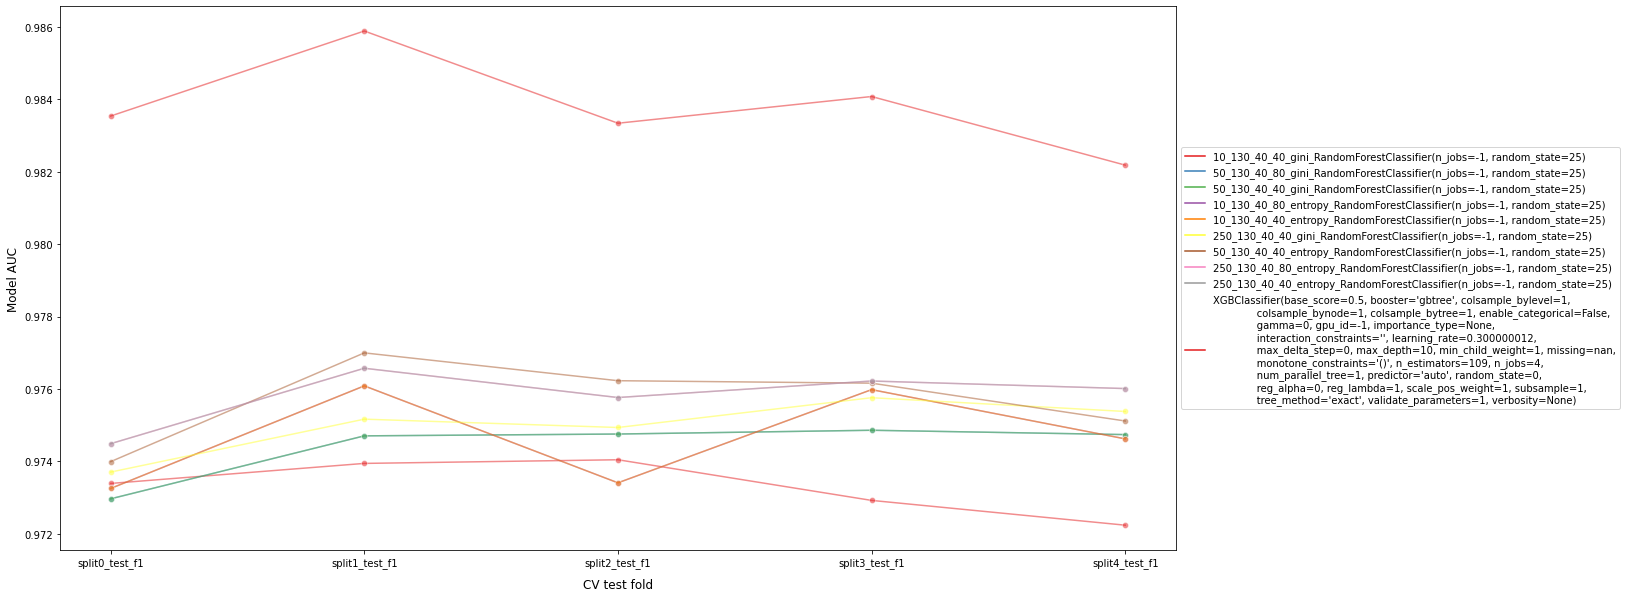

In [19]:
import seaborn as sns
model_scores = results_df.filter(regex=r"split\d*_test_f1")
print(model_scores)

fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(
    data=model_scores.transpose().iloc[:5],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [20]:
print(rf_random.best_estimator_)
rf_random.best_params_

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=10, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])


{'classifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=109, n_jobs=4,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)}

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[18:26:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:26:43] WARNING: C:/Users/Administrator/workspac

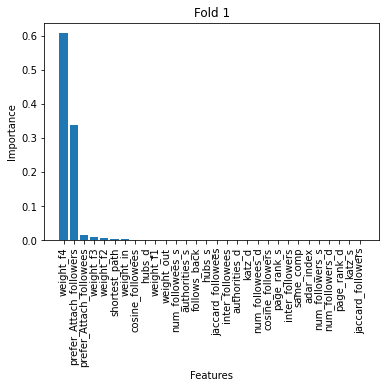

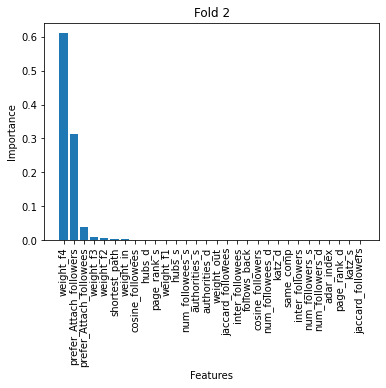

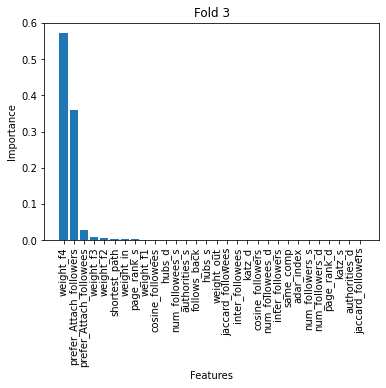

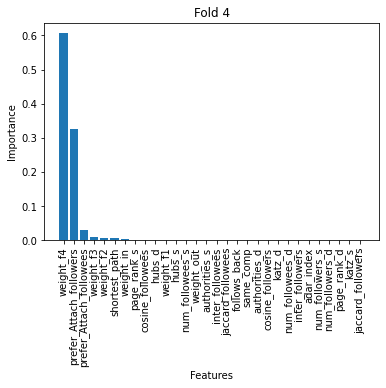

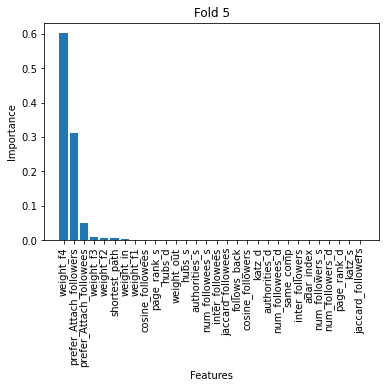

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

# feature names must be declared outside the function
feature_names = list(df_final_train.columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
rfc = rf_random.best_estimator_._final_estimator
print(rfc)
count = 1
# test data is not needed for fitting
for train, _ in kf.split(df_final_train, y_train):
    rfc.fit(df_final_train.iloc[train, :], y_train.iloc[train])
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

## Random Forest

RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


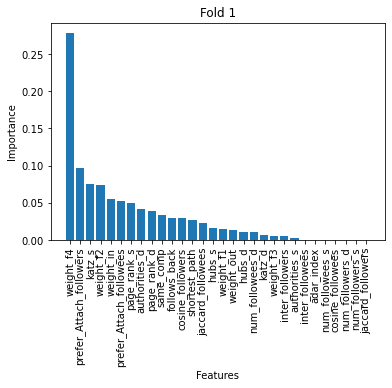

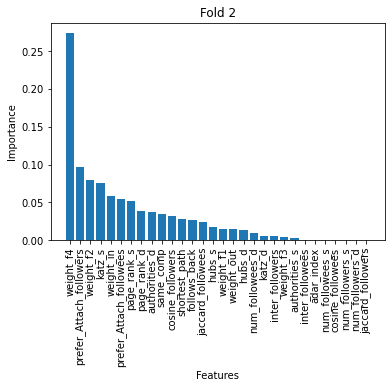

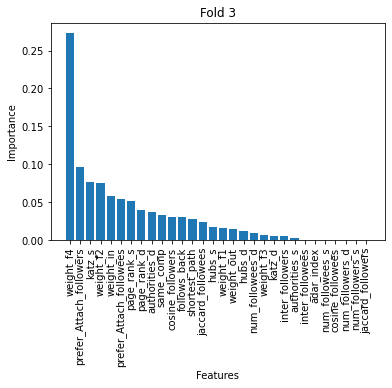

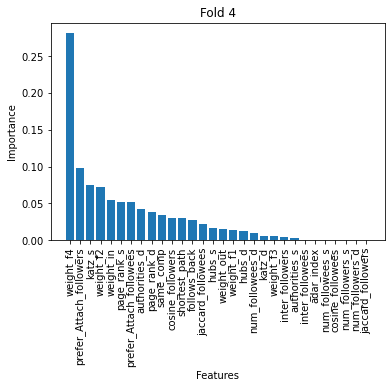

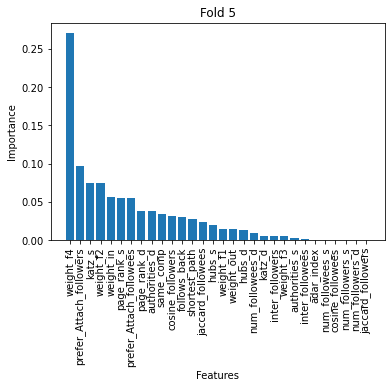

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

# classification dataset
#data_x, data_y = make_classification(n_features=9)

# feature names must be declared outside the function
feature_names = list(df_final_train.columns)

kf = KFold(n_splits=5,random_state=25,shuffle=True)
rfc = RandomForestClassifier(max_depth=35, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)
print(rfc)
count = 1
# test data is not needed for fitting
for train, _ in kf.split(df_final_train, y_train):
    rfc.fit(df_final_train.iloc[train, :], y_train.iloc[train])
    # sort the feature index by importance score in descending order
    importances_index_desc = np.argsort(rfc.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, rfc.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count = count + 1
plt.show()

## Lightgbm

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008967 seconds.
You can set `force_col_wise=true` to remove the overhead.
Plotting metrics recorded during training...


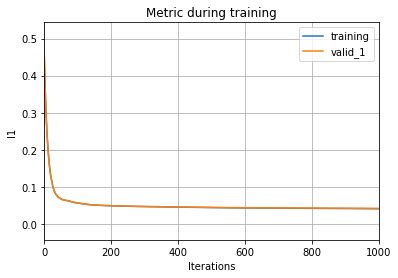

Plotting feature importances...


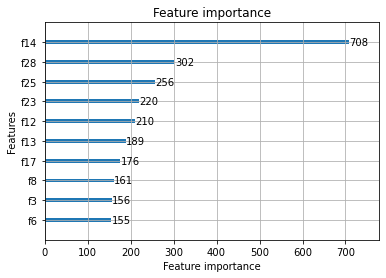

Plotting 54th tree...


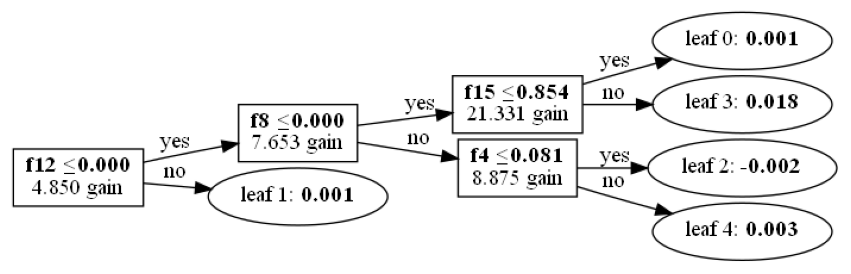

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009291 seconds.
You can set `force_col_wise=true` to remove the overhead.
Plotting metrics recorded during training...


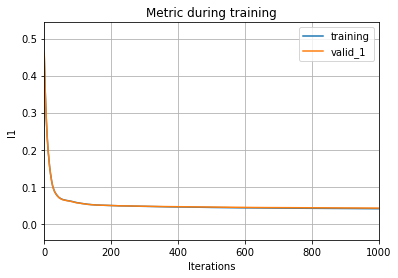

Plotting feature importances...


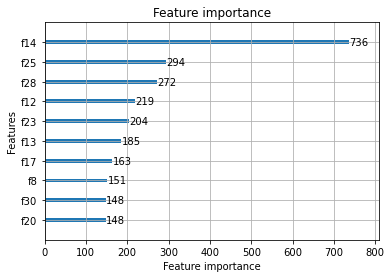

Plotting 54th tree...


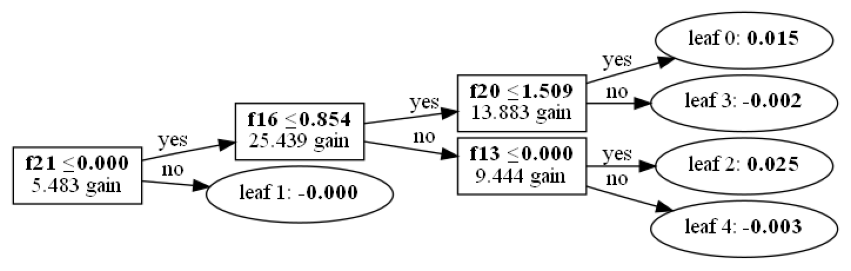

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009195 seconds.
You can set `force_col_wise=true` to remove the overhead.
Plotting metrics recorded during training...


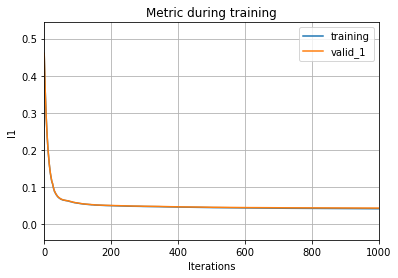

Plotting feature importances...


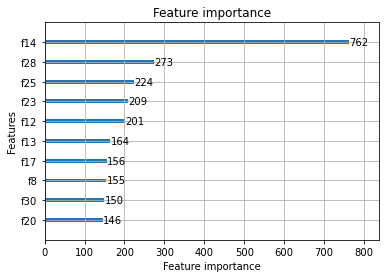

Plotting 54th tree...


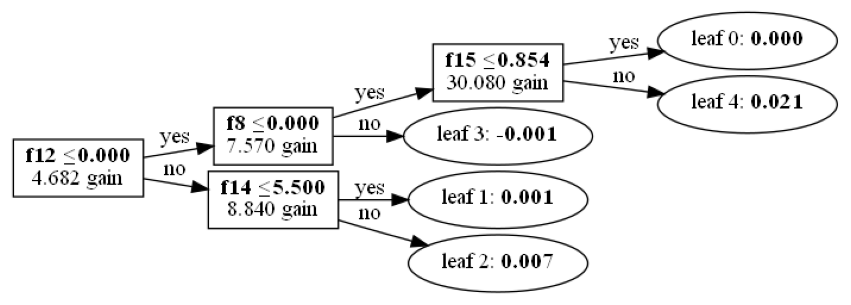

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009890 seconds.
You can set `force_col_wise=true` to remove the overhead.
Plotting metrics recorded during training...


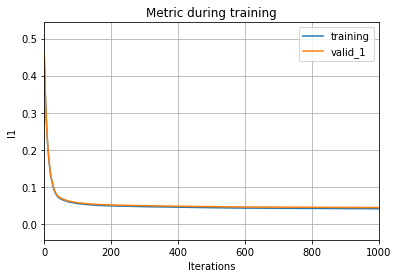

Plotting feature importances...


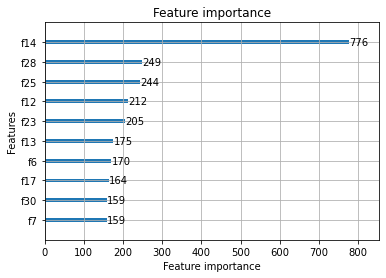

Plotting 54th tree...


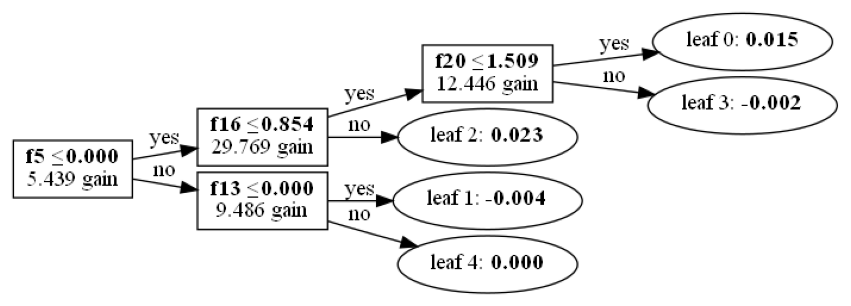

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009031 seconds.
You can set `force_col_wise=true` to remove the overhead.
Plotting metrics recorded during training...


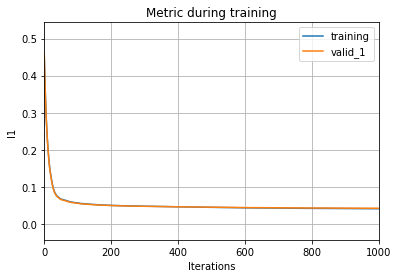

Plotting feature importances...


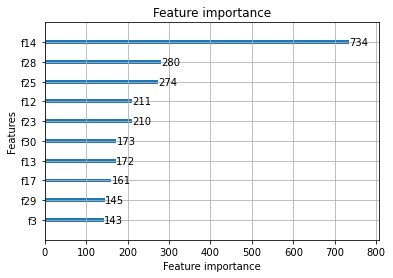

Plotting 54th tree...


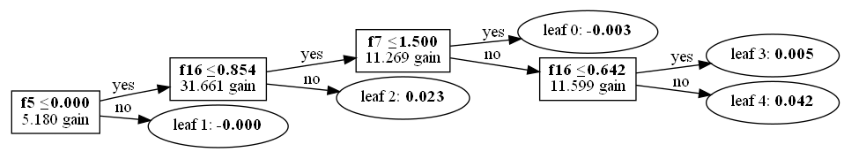

In [23]:
#!pip install lightgbm
#!pip install graphviz
import lightgbm as lgb
from sklearn.metrics import f1_score


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True


...
# configure the cross-validation procedure
cv = KFold(n_splits=5, random_state=25,shuffle=True)
# perform cross-validation procedure
for train_ix, test_ix in cv.split(df_final_train):
    # split data
    X_train, X_test = df_final_train.iloc[train_ix, :], df_final_train.iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # fit and evaluate a model



    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train_lgb)
    lgb_test = lgb.Dataset(X_test, y_test_lgb, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'num_leaves': 5,
        'metric': ('l1', 'l2'),
        'verbose': 0
    }

    evals_result = {}  # to record eval results for plotting

    print('Starting training...')
    # train
    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_test],
        feature_name=[f'f{i + 1}' for i in range(df_final_train.shape[-1])],
        categorical_feature=[21],
        callbacks=[
            lgb.record_evaluation(evals_result)
        ]
    )

    print('Plotting metrics recorded during training...')
    ax = lgb.plot_metric(evals_result, metric='l1')
    plt.show()

    print('Plotting feature importances...')
    ax = lgb.plot_importance(gbm, max_num_features=10)
    plt.show()



    print('Plotting 54th tree...')  # one tree use categorical feature to split
    ax = lgb.plot_tree(gbm, tree_index=53, figsize=(15, 15), show_info=['split_gain'])
    plt.show()

#     print('Plotting 54th tree with graphviz...')
#     graph = lgb.create_tree_digraph(gbm, tree_index=53, name='Tree54')
#     graph.render(view=True)

LightGBM Model accuracy score: 0.9851
LightGBM Model f1 score: 0.9850
LightGBM Model recall score: 0.9782


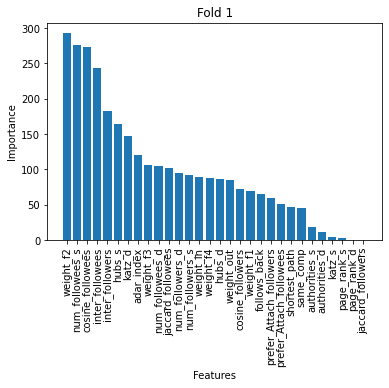

LightGBM Model accuracy score: 0.9829
LightGBM Model f1 score: 0.9825
LightGBM Model recall score: 0.9757


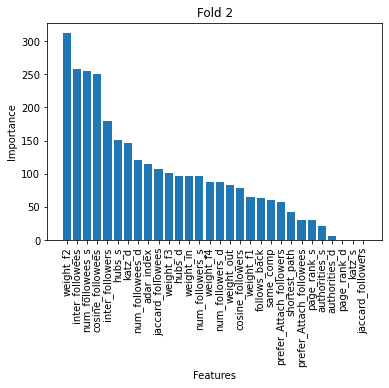

LightGBM Model accuracy score: 0.9838
LightGBM Model f1 score: 0.9838
LightGBM Model recall score: 0.9769


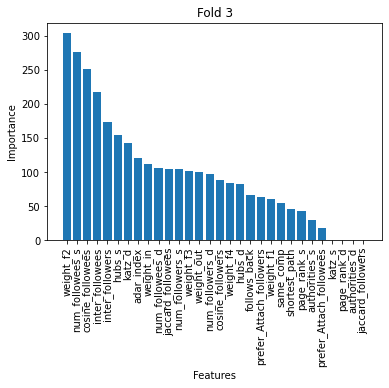

LightGBM Model accuracy score: 0.9830
LightGBM Model f1 score: 0.9827
LightGBM Model recall score: 0.9751


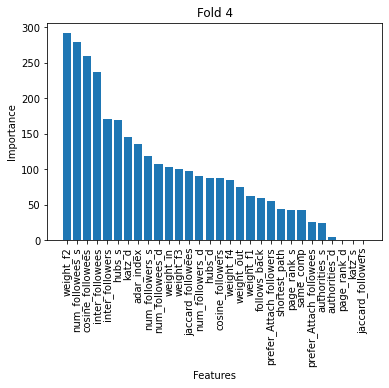

LightGBM Model accuracy score: 0.9843
LightGBM Model f1 score: 0.9843
LightGBM Model recall score: 0.9779


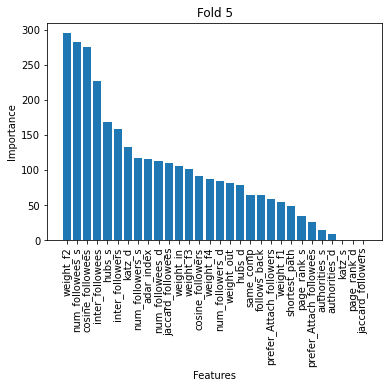

In [24]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


feature_names = list(df_final_train.columns)


cv = KFold(n_splits=5, random_state=25,shuffle=True)
# perform cross-validation procedure
count=1
for train_ix, test_ix in cv.split(df_final_train):
    # split data
    X_train, X_test = df_final_train.iloc[train_ix, :], df_final_train.iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]
    clf = lgb.LGBMClassifier()
    clf.fit(X_train, y_train_lgb)

    y_pred=clf.predict(X_test)
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, y_pred)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, y_pred)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, y_pred)))
    
    importances_index_desc = np.argsort(clf.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, clf.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count=count+1
    plt.show()


[18:28:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LightGBM Model accuracy score: 0.9854
LightGBM Model f1 score: 0.9853
LightGBM Model recall score: 0.9797


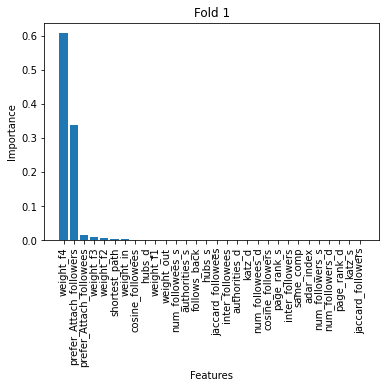

[18:28:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LightGBM Model accuracy score: 0.9845
LightGBM Model f1 score: 0.9841
LightGBM Model recall score: 0.9786


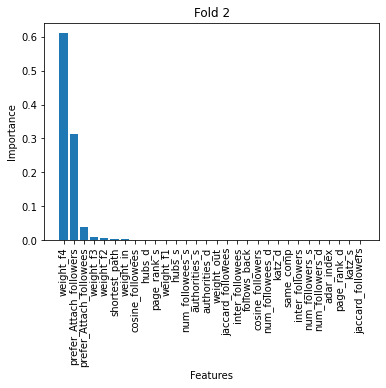

[18:28:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LightGBM Model accuracy score: 0.9836
LightGBM Model f1 score: 0.9835
LightGBM Model recall score: 0.9780


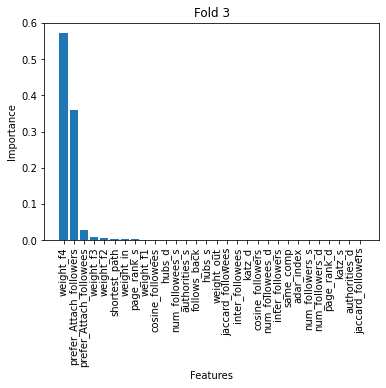

[18:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LightGBM Model accuracy score: 0.9835
LightGBM Model f1 score: 0.9832
LightGBM Model recall score: 0.9757


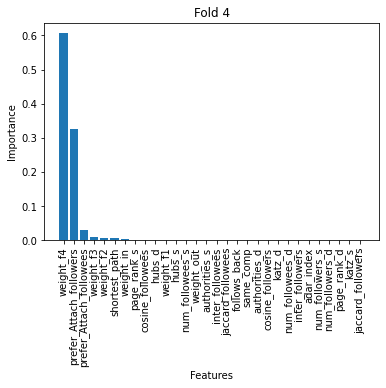

[18:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LightGBM Model accuracy score: 0.9841
LightGBM Model f1 score: 0.9841
LightGBM Model recall score: 0.9797


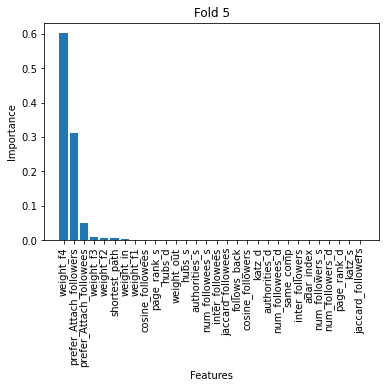

In [25]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import pickle


clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
          gamma=0, gpu_id=-1, importance_type=None,
          interaction_constraints='', learning_rate=0.300000012,
          max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
          monotone_constraints='()', n_estimators=109, n_jobs=4,
          num_parallel_tree=1, predictor='auto', random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
          tree_method='exact', validate_parameters=1, verbosity=None)
feature_names = list(df_final_train.columns)


cv = KFold(n_splits=5, random_state=25,shuffle=True)
# perform cross-validation procedure
count=1
for train_ix, test_ix in cv.split(df_final_train):
    # split data
    X_train, X_test = df_final_train.iloc[train_ix, :], df_final_train.iloc[test_ix, :]
    y_train_lgb, y_test_lgb = y_train.iloc[train_ix], y_train.iloc[test_ix]
    clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=np.nan,
              monotone_constraints='()', n_estimators=109, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
    clf.fit(X_train, y_train_lgb)

    y_pred=clf.predict(X_test)
    print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_lgb, y_pred)))
    print('LightGBM Model f1 score: {0:0.4f}'.format(f1_score(y_test_lgb, y_pred)))
    print('LightGBM Model recall score: {0:0.4f}'.format(recall_score(y_test_lgb, y_pred)))
    
    importances_index_desc = np.argsort(clf.feature_importances_)[::-1]
    feature_labels = [feature_names[-i] for i in importances_index_desc]

    # plot
    plt.figure()
    plt.bar(feature_labels, clf.feature_importances_[importances_index_desc])
    plt.xticks(feature_labels, rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Fold {}'.format(count))
    count=count+1
    plt.show()

filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [26]:
clf.predict_proba(X_test)

array([[2.7418137e-06, 9.9999726e-01],
       [7.2479248e-05, 9.9992752e-01],
       [3.1232834e-05, 9.9996877e-01],
       ...,
       [9.9999487e-01, 5.1338411e-06],
       [9.9404782e-01, 5.9521892e-03],
       [9.9724710e-01, 2.7529174e-03]], dtype=float32)